### Введение
С развитием LLM-моделей спрашивать теоретическую часть или короткие алгоритмы и принципы стало бесполезно, поэтому задание будет одно, но комплексное и приближенное к реальности.

Вы можете использовать любые LLM-модели и Copilot для написания кода, так как в реальной работе сотрудники отдела также имеют доступ ко всем современным инструментам (Sonnet 3.5, GPT-4o, GitHub Copilot и т. п.).

В задании вы будете работать с тестовыми данными по банкоматам и API ЦБ РФ для получения ключевой ставки.

---

### Специфика данных fees
`fees` — тарифы за обслуживание банкомата инкассаторами. Так как банкоматы могут находиться в разных регионах, тарифы у них могут отличаться.

- **CashDeliveryFixedFee** — фиксированная стоимость доставки наличных (не зависит от суммы).
- **CashDeliveryPercentageFee** — процент от суммы доставленных наличных. Он добавляется к фиксированной стоимости. Если в таблице указано `0.0001`, это значит 0.01% от суммы.
- **CashDeliveryMinFee** — минимальная сумма, которую с нас возьмут по `CashDeliveryPercentageFee`. Например, если мы попросим инкассаторов в ATM_4 довезти всего 10 000 рублей, то с нас возьмут 5250 рублей (фиксированная стоимость), а так как `10 000 * 0.04% < 450 рублей`, то дополнительно возьмут ещё 450 рублей. Итог: 5250 + 450 рублей.

**CashCollection** — это пример сложного тарифа, который учитывает специфику работы с банкоматом. В банкомат деньги не докладывают, а меняют сразу кассету. Есть провайдеры, которые тарифицируют не только доставку, но и пересчёт денег в извлечённой кассете. Например, в ATM_4 у нас именно такой тариф.  
Пример: у нас в банкомате осталось 500 тыс. рублей, а мы хотим, чтобы у него был баланс 2 млн. Тогда мы заказываем довезти кассету на 2 млн. и платим по тарифу за доставку. При доставке старая кассета извлекается, и мы также по тарифу платим за пересчёт 500 тыс. рублей (0.45%, но не менее 1140 рублей).

- **CashCollectionFixedFee** — фиксированная стоимость за извлечение старой кассеты (в данных примерах нулевая).
- **CashCollectionPercentageFee** — процент от суммы извлечённой кассеты.
- **CashCollectionMinFee** — минимальная сумма, которую с нас возьмут по `CashCollectionPercentageFee`.

---

### Специфика данных transactions
Таблица содержит данные по снятиям, пополнениям (инкассациям) и балансу банкомата на конец дня.  
Считаем, что банкоматы в начале года пустые и не работали, поэтому баланс на конец дня равен 0, пока не случится первая инкассация.

- **bal_end_of_day** — баланс на конец дня.
- **cash_in** — пополнение в результате инкассации.
- **cash_out** — снятие наличных клиентами.

---

In [292]:
import numpy as np
import requests
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import warnings

In [ ]:
warnings.filterwarnings('ignore')

In [1]:
fees = pd.read_parquet('https://storage.yandexcloud.net/norvpublic/fees.parquet')
transactions = pd.read_parquet('https://storage.yandexcloud.net/norvpublic/transactions.parquet')

In [2]:
fees = fees.fillna(0)
fees

,ATM_ID,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee
0,ATM_1,1365.0,0.0001,0.0,0.0,0.0000,0.0
1,ATM_2,1365.0,0.0001,0.0,0.0,0.0000,0.0
2,ATM_4,5250.0,0.0004,450.0,0.0,0.0045,1140.0
3,ATM_3,2250.0,0.0001,675.0,0.0,0.0000,0.0


In [3]:
transactions

,date,ATM_ID,bal_end_of_day,cash_in,cash_out
0,2024-01-12 00:00:00+00:00,ATM_1,0.0,0.0,0.0
1,2024-01-12 00:00:00+00:00,ATM_2,0.0,0.0,0.0
2,2024-01-12 00:00:00+00:00,ATM_3,0.0,0.0,0.0
3,2024-01-12 00:00:00+00:00,ATM_4,0.0,0.0,0.0
4,2024-01-13 00:00:00+00:00,ATM_1,0.0,0.0,0.0
...,...,...,...,...,...
1171,2024-10-30 00:00:00+00:00,ATM_4,747650.0,0.0,1000.0
1172,2024-10-31 00:00:00+00:00,ATM_1,3215500.0,0.0,171600.0
1173,2024-10-31 00:00:00+00:00,ATM_2,4754600.0,0.0,395100.0
1174,2024-10-31 00:00:00+00:00,ATM_3,2277000.0,0.0,1000.0


In [4]:
from_date = transactions["date"].min().strftime('%Y-%m-%d')
to_date = transactions["date"].max().strftime('%Y-%m-%d')

### Часть 1 — упущенный процентный доход

Специалисту по ML важно уметь получать данные с различных API и читать документацию. Для расчёта упущенного процентного дохода нужно обратиться к API ЦБ РФ и получить динамику ключевой ставки за 2024 год.

https://www.cbr.ru/DailyInfoWebServ/DailyInfo.asmx?op=KeyRate

Для запроса к API не нужен токен и регистрация. ЦБ РФ для части данных предпочитает использовать SOAP.

Учитывая, что хранить наличные деньги в банкомате — не самое удачное инвестиционное решение, посчитайте упущенный процентный доход для каждого банкомата. Рассчитываем, что банк мог бы вложить эти деньги и получить доход, равный ключевой ставке ЦБ РФ, актуальной на день баланса банкомата. Добавьте к таблице `transactions` столбец с упущенной процентной выгодой.


In [5]:
url = "https://www.cbr.ru/DailyInfoWebServ/DailyInfo.asmx"
headers = {
    "Content-Type": "text/xml; charset=utf-8",
    "SOAPAction": "http://web.cbr.ru/KeyRate"
}

soap_body = f"""<?xml version="1.0" encoding="utf-8"?>
<soap:Envelope xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" 
               xmlns:xsd="http://www.w3.org/2001/XMLSchema" 
               xmlns:soap="http://schemas.xmlsoap.org/soap/envelope/">
  <soap:Body>
    <KeyRate xmlns="http://web.cbr.ru/">
      <fromDate>{from_date}</fromDate>
      <ToDate>{to_date}</ToDate>
    </KeyRate>
  </soap:Body>
</soap:Envelope>"""

response = requests.post(url, data=soap_body, headers=headers)

In [6]:
response_text = response.text
dates = re.findall(r"<DT>(.*?)</DT>", response_text)
rates = re.findall(r"<Rate>(.*?)</Rate>", response_text)

if dates and rates:
    data = {"date": dates, "rate": rates}
    df = pd.DataFrame(data)

    df["date"] = pd.to_datetime(df["date"])
    df["rate"] = pd.to_numeric(df["rate"])
else:
    print("No valid KeyRate data found in the response.")

In [7]:
df

,date,rate
0,2024-10-31 00:00:00+03:00,21.0
1,2024-10-30 00:00:00+03:00,21.0
2,2024-10-29 00:00:00+03:00,21.0
3,2024-10-28 00:00:00+03:00,21.0
4,2024-10-25 00:00:00+03:00,19.0
...,...,...
201,2024-01-18 00:00:00+03:00,16.0
202,2024-01-17 00:00:00+03:00,16.0
203,2024-01-16 00:00:00+03:00,16.0
204,2024-01-15 00:00:00+03:00,16.0


In [8]:
full_date_range = pd.date_range(start="2024-01-12", end="2024-10-31", freq="D", tz="Europe/Moscow")

full_df = pd.DataFrame({"date": full_date_range})

merged_df = pd.merge(full_df, df, on="date", how="left")

merged_df["rate"] = merged_df["rate"].ffill()

In [9]:
merged_df

,date,rate
0,2024-01-12 00:00:00+03:00,16.0
1,2024-01-13 00:00:00+03:00,16.0
2,2024-01-14 00:00:00+03:00,16.0
3,2024-01-15 00:00:00+03:00,16.0
4,2024-01-16 00:00:00+03:00,16.0
...,...,...
289,2024-10-27 00:00:00+03:00,19.0
290,2024-10-28 00:00:00+03:00,21.0
291,2024-10-29 00:00:00+03:00,21.0
292,2024-10-30 00:00:00+03:00,21.0


In [10]:
merged_df["date"] = merged_df["date"].dt.date

In [11]:
transactions["date"] = transactions["date"].dt.date

In [12]:
transactions = pd.merge(transactions, merged_df, on="date", how='left')
transactions

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,rate
0,2024-01-12,ATM_1,0.0,0.0,0.0,16.0
1,2024-01-12,ATM_2,0.0,0.0,0.0,16.0
2,2024-01-12,ATM_3,0.0,0.0,0.0,16.0
3,2024-01-12,ATM_4,0.0,0.0,0.0,16.0
4,2024-01-13,ATM_1,0.0,0.0,0.0,16.0
...,...,...,...,...,...,...
1171,2024-10-30,ATM_4,747650.0,0.0,1000.0,21.0
1172,2024-10-31,ATM_1,3215500.0,0.0,171600.0,21.0
1173,2024-10-31,ATM_2,4754600.0,0.0,395100.0,21.0
1174,2024-10-31,ATM_3,2277000.0,0.0,1000.0,21.0


In [13]:
transactions["rate"].isna().sum()

0

In [14]:
transactions["potential_benefits"] = transactions["bal_end_of_day"] * (transactions["rate"] / 100)
transactions

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,rate,potential_benefits
0,2024-01-12,ATM_1,0.0,0.0,0.0,16.0,0.0
1,2024-01-12,ATM_2,0.0,0.0,0.0,16.0,0.0
2,2024-01-12,ATM_3,0.0,0.0,0.0,16.0,0.0
3,2024-01-12,ATM_4,0.0,0.0,0.0,16.0,0.0
4,2024-01-13,ATM_1,0.0,0.0,0.0,16.0,0.0
...,...,...,...,...,...,...,...
1171,2024-10-30,ATM_4,747650.0,0.0,1000.0,21.0,157006.5
1172,2024-10-31,ATM_1,3215500.0,0.0,171600.0,21.0,675255.0
1173,2024-10-31,ATM_2,4754600.0,0.0,395100.0,21.0,998466.0
1174,2024-10-31,ATM_3,2277000.0,0.0,1000.0,21.0,478170.0


### Часть 2 - расходы на инкассацию

Теперь к данным по банкоматам, кроме упущенного процентного дохода, необходимо добавить столбец расходов на инкассацию. Для простоты считаем, что мы не платим за аренду помещения и страхование, поэтому нам достаточно данных по тарифам на инкассацию (`fees`).

In [15]:
transactions_fees = pd.merge(transactions, fees, on="ATM_ID", how="inner")
transactions_fees

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,rate,potential_benefits,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee
0,2024-01-12,ATM_1,0.0,0.0,0.0,16.0,0.0,1365.0,0.0001,0.0,0.0,0.0000,0.0
1,2024-01-12,ATM_2,0.0,0.0,0.0,16.0,0.0,1365.0,0.0001,0.0,0.0,0.0000,0.0
2,2024-01-12,ATM_3,0.0,0.0,0.0,16.0,0.0,2250.0,0.0001,675.0,0.0,0.0000,0.0
3,2024-01-12,ATM_4,0.0,0.0,0.0,16.0,0.0,5250.0,0.0004,450.0,0.0,0.0045,1140.0
4,2024-01-13,ATM_1,0.0,0.0,0.0,16.0,0.0,1365.0,0.0001,0.0,0.0,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,2024-10-30,ATM_4,747650.0,0.0,1000.0,21.0,157006.5,5250.0,0.0004,450.0,0.0,0.0045,1140.0
1172,2024-10-31,ATM_1,3215500.0,0.0,171600.0,21.0,675255.0,1365.0,0.0001,0.0,0.0,0.0000,0.0
1173,2024-10-31,ATM_2,4754600.0,0.0,395100.0,21.0,998466.0,1365.0,0.0001,0.0,0.0,0.0000,0.0
1174,2024-10-31,ATM_3,2277000.0,0.0,1000.0,21.0,478170.0,2250.0,0.0001,675.0,0.0,0.0000,0.0


In [16]:
transactions_fees = transactions_fees.sort_values(by=["ATM_ID", "date"])

transactions_fees["lag_balance"] = transactions_fees.groupby("ATM_ID")["bal_end_of_day"].shift(1)

transactions_fees

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,rate,potential_benefits,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee,lag_balance
0,2024-01-12,ATM_1,0.0,0.0,0.0,16.0,0.0,1365.0,0.0001,0.0,0.0,0.0000,0.0,NaN
4,2024-01-13,ATM_1,0.0,0.0,0.0,16.0,0.0,1365.0,0.0001,0.0,0.0,0.0000,0.0,0.0
8,2024-01-14,ATM_1,0.0,0.0,0.0,16.0,0.0,1365.0,0.0001,0.0,0.0,0.0000,0.0,0.0
12,2024-01-15,ATM_1,0.0,0.0,0.0,16.0,0.0,1365.0,0.0001,0.0,0.0,0.0000,0.0,0.0
16,2024-01-16,ATM_1,0.0,0.0,0.0,16.0,0.0,1365.0,0.0001,0.0,0.0,0.0000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159,2024-10-27,ATM_4,752650.0,0.0,0.0,19.0,143003.5,5250.0,0.0004,450.0,0.0,0.0045,1140.0,752650.0
1163,2024-10-28,ATM_4,752650.0,0.0,0.0,21.0,158056.5,5250.0,0.0004,450.0,0.0,0.0045,1140.0,752650.0
1167,2024-10-29,ATM_4,748650.0,0.0,4000.0,21.0,157216.5,5250.0,0.0004,450.0,0.0,0.0045,1140.0,752650.0
1171,2024-10-30,ATM_4,747650.0,0.0,1000.0,21.0,157006.5,5250.0,0.0004,450.0,0.0,0.0045,1140.0,748650.0


In [18]:
transactions_fees["incassary_price"] = np.where(
    transactions_fees["cash_in"] > 0.0, 
    transactions_fees["CashDeliveryFixedFee"]
    + np.maximum(
        transactions_fees["CashDeliveryPercentageFee"] * transactions_fees["cash_in"],
        transactions_fees["CashDeliveryMinFee"],
    )
    + transactions_fees["CashCollectionFixedFee"]
    + np.maximum(
        transactions_fees["CashCollectionPercentageFee"] * transactions_fees["lag_balance"],
        transactions_fees["CashCollectionMinFee"],
    ),
    0.0,
)

transactions_fees["incassary_price"] = transactions_fees["incassary_price"].fillna(0.0)
transactions_fees

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,rate,potential_benefits,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee,lag_balance,incassary_price
0,2024-01-12,ATM_1,0.0,0.0,0.0,16.0,0.0,1365.0,0.0001,0.0,0.0,0.0000,0.0,NaN,0.0
4,2024-01-13,ATM_1,0.0,0.0,0.0,16.0,0.0,1365.0,0.0001,0.0,0.0,0.0000,0.0,0.0,0.0
8,2024-01-14,ATM_1,0.0,0.0,0.0,16.0,0.0,1365.0,0.0001,0.0,0.0,0.0000,0.0,0.0,0.0
12,2024-01-15,ATM_1,0.0,0.0,0.0,16.0,0.0,1365.0,0.0001,0.0,0.0,0.0000,0.0,0.0,0.0
16,2024-01-16,ATM_1,0.0,0.0,0.0,16.0,0.0,1365.0,0.0001,0.0,0.0,0.0000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159,2024-10-27,ATM_4,752650.0,0.0,0.0,19.0,143003.5,5250.0,0.0004,450.0,0.0,0.0045,1140.0,752650.0,0.0
1163,2024-10-28,ATM_4,752650.0,0.0,0.0,21.0,158056.5,5250.0,0.0004,450.0,0.0,0.0045,1140.0,752650.0,0.0
1167,2024-10-29,ATM_4,748650.0,0.0,4000.0,21.0,157216.5,5250.0,0.0004,450.0,0.0,0.0045,1140.0,752650.0,0.0
1171,2024-10-30,ATM_4,747650.0,0.0,1000.0,21.0,157006.5,5250.0,0.0004,450.0,0.0,0.0045,1140.0,748650.0,0.0


In [19]:
assert transactions_fees[transactions_fees["incassary_price"] > 0.0].shape[0] == transactions_fees[transactions_fees["cash_in"] > 0.0].shape[0]

### Часть 3 - анализ данных

Посмотрите на данные о снятиях, инкассациях и балансе. В данных подобраны банкоматы, отличающиеся по характеру использования и частоте инкассаций.  
(Эту операцию вы делаете для себя, чтобы лучше понять специфику.)

<Axes: xlabel='date', ylabel='cash_out'>

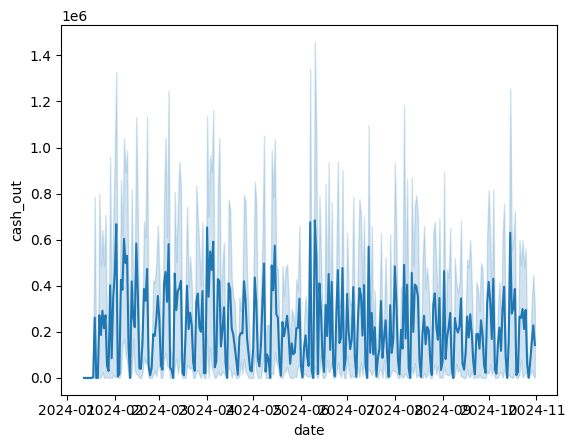

In [20]:
sns.lineplot(transactions_fees, x="date", y="cash_out")

In [57]:
def incassary_count(trans_df, atm: str):
    df_a = trans_df[trans_df["ATM_ID"] == atm]
    print(f'incassary count for {atm} is: {df_a[df_a["cash_in"] > 0.0].shape[0]}')

def no_cash_out_days(trans_df, atm: str):
    df_a = trans_df[trans_df["ATM_ID"] == atm]
    print(f'no cash out days for {atm} is: {df_a[df_a["cash_out"] == 0.0].shape[0]}')

def plot_data_grouped(df_f, xlabel="", ylabel="", title="", group_column="dweek", column="cash_out", xticks=[], 
                        plot_func=sns.barplot):
    df_group = df_f.groupby(group_column)[column].sum()
    plt.figure(figsize=(10, 6))
    plot_func(x=df_group.index, y=df_group.values)
    if title != "":
        plt.title(title, fontsize=16)
    else:
        plt.title(f"Number of {column} by {group_column}", fontsize=16)
    if xlabel != "":
        plt.xlabel(xlabel, fontsize=14)
    else:
        plt.xlabel(f"{group_column}", fontsize=14)
    if ylabel != "":
        plt.ylabel(ylabel, fontsize=14)
    else:
        plt.ylabel(f"Number of {column}", fontsize=14)
    if len(xticks) > 0:
        if group_column == "month":
            plt.xticks(np.arange(1, len(xticks)+1), xticks)
        else:
            plt.xticks(np.arange(len(xticks)), xticks)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_data_per_atm(transactions_fees, atm):
    t_fees_atm = transactions_fees[transactions_fees["ATM_ID"] == atm]
    plot_data_grouped(t_fees_atm, group_column="month",
                      xticks=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
                     plot_func=sns.lineplot)
    
    f, axs = plt.subplots(2, 2, figsize=(30, 20))
    ax1 = axs[0, 0]
    ax2 = axs[0, 1]
    ax3 = axs[1, 0]
    ax4 = axs[1, 1]
    ax1.set_title("Potentinal benefits", fontsize=14)
    ax1.set_xlabel("date", fontsize=12)
    ax1.set_ylabel("potential_benefits", fontsize=12)
    sns.lineplot(t_fees_atm, x="date", y="potential_benefits", ax=ax1)
    ax2.set_title("cash_out per day", fontsize=14)
    ax2.set_xlabel("date", fontsize=12)
    ax2.set_ylabel("cash_out", fontsize=12)
    sns.lineplot(t_fees_atm, x="date", y="cash_out", ax=ax2)
    ax3.set_title("bal_end_of_day per day", fontsize=14)
    ax3.set_xlabel("date", fontsize=12)
    ax3.set_ylabel("bal_end_of_day", fontsize=12)
    sns.lineplot(t_fees_atm, x="date", y="bal_end_of_day", ax=ax3)
    ax4.set_title("cash_in per day", fontsize=14)
    ax4.set_xlabel("date", fontsize=12)
    ax4.set_ylabel("cash_in", fontsize=12)
    sns.lineplot(t_fees_atm, x="date", y="cash_in", ax=ax4)
    display(t_fees_atm[t_fees_atm["cash_in"]>0.0])
    plot_data_grouped(transactions_fees[transactions_fees["ATM_ID"] == atm], group_column="dweek",
                      xticks=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
    plot_data_grouped(transactions_fees[transactions_fees["ATM_ID"] == atm], group_column="dweek", column="cash_in",
                      xticks=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

In [26]:
transactions_fees["cash_out_calc"] = transactions_fees["lag_balance"].fillna(0) - transactions_fees["bal_end_of_day"]
transactions_fees[transactions_fees["cash_out_calc"] != transactions_fees["cash_out"]]

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,rate,potential_benefits,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee,lag_balance,incassary_price,cash_out_calc
44,2024-01-23,ATM_1,6525100.0,6620000.0,94900.0,16.0,1044016.0,1365.0,0.0001,0.0,0.0,0.0000,0.0,0.0,2027.000,-6525100.0
100,2024-02-06,ATM_1,5974000.0,6620000.0,646000.0,16.0,955840.0,1365.0,0.0001,0.0,0.0,0.0000,0.0,1528300.0,2027.000,-4445700.0
128,2024-02-13,ATM_1,6396300.0,6620000.0,223700.0,16.0,1023408.0,1365.0,0.0001,0.0,0.0,0.0000,0.0,1252200.0,2027.000,-5144100.0
164,2024-02-22,ATM_1,5156900.0,6620000.0,1463100.0,16.0,825104.0,1365.0,0.0001,0.0,0.0,0.0000,0.0,1989000.0,2027.000,-3167900.0
212,2024-03-05,ATM_1,6458200.0,6620000.0,161800.0,16.0,1033312.0,1365.0,0.0001,0.0,0.0,0.0000,0.0,1828700.0,2027.000,-4629500.0
252,2024-03-15,ATM_1,6258900.0,6620000.0,361100.0,16.0,1001424.0,1365.0,0.0001,0.0,0.0,0.0000,0.0,680300.0,2027.000,-5578600.0
304,2024-03-28,ATM_1,6306600.0,6620000.0,313400.0,16.0,1009056.0,1365.0,0.0001,0.0,0.0,0.0000,0.0,1489000.0,2027.000,-4817600.0
348,2024-04-08,ATM_1,5864200.0,6620000.0,755800.0,16.0,938272.0,1365.0,0.0001,0.0,0.0,0.0000,0.0,233100.0,2027.000,-5631100.0
388,2024-04-18,ATM_1,6303100.0,6620000.0,316900.0,16.0,1008496.0,1365.0,0.0001,0.0,0.0,0.0000,0.0,2172700.0,2027.000,-4130400.0
460,2024-05-06,ATM_1,6545500.0,6620000.0,74500.0,16.0,1047280.0,1365.0,0.0001,0.0,0.0,0.0000,0.0,1849900.0,2027.000,-4695600.0


In [27]:
transactions_fees["date"] = pd.to_datetime(transactions_fees["date"], format='%Y-%m-%d')
print(transactions_fees["date"].dtype)
transactions_fees["date"]

datetime64[ns]


0      2024-01-12
4      2024-01-13
8      2024-01-14
12     2024-01-15
16     2024-01-16
          ...    
1159   2024-10-27
1163   2024-10-28
1167   2024-10-29
1171   2024-10-30
1175   2024-10-31
Name: date, Length: 1176, dtype: datetime64[ns]

In [28]:
transactions_fees["dweek"] = transactions_fees["date"].dt.dayofweek
transactions_fees["dayofmonth"] = transactions_fees["date"].dt.day
transactions_fees["month"] = transactions_fees["date"].dt.month
transactions_fees

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,rate,potential_benefits,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee,lag_balance,incassary_price,cash_out_calc,dweek,dayofmonth,month
0,2024-01-12,ATM_1,0.0,0.0,0.0,16.0,0.0,1365.0,0.0001,0.0,0.0,0.0000,0.0,NaN,0.0,0.0,4,12,1
4,2024-01-13,ATM_1,0.0,0.0,0.0,16.0,0.0,1365.0,0.0001,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,5,13,1
8,2024-01-14,ATM_1,0.0,0.0,0.0,16.0,0.0,1365.0,0.0001,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,6,14,1
12,2024-01-15,ATM_1,0.0,0.0,0.0,16.0,0.0,1365.0,0.0001,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0,15,1
16,2024-01-16,ATM_1,0.0,0.0,0.0,16.0,0.0,1365.0,0.0001,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,1,16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159,2024-10-27,ATM_4,752650.0,0.0,0.0,19.0,143003.5,5250.0,0.0004,450.0,0.0,0.0045,1140.0,752650.0,0.0,0.0,6,27,10
1163,2024-10-28,ATM_4,752650.0,0.0,0.0,21.0,158056.5,5250.0,0.0004,450.0,0.0,0.0045,1140.0,752650.0,0.0,0.0,0,28,10
1167,2024-10-29,ATM_4,748650.0,0.0,4000.0,21.0,157216.5,5250.0,0.0004,450.0,0.0,0.0045,1140.0,752650.0,0.0,4000.0,1,29,10
1171,2024-10-30,ATM_4,747650.0,0.0,1000.0,21.0,157006.5,5250.0,0.0004,450.0,0.0,0.0045,1140.0,748650.0,0.0,1000.0,2,30,10


In [29]:
transactions_fees_cas = transactions_fees[transactions_fees["cash_out"] > 0.0]
print(transactions_fees_cas["dayofmonth"].median())
transactions_fees_cas["dayofmonth"].value_counts()

16.0


dayofmonth
22    33
26    32
23    30
25    30
27    30
15    30
17    30
13    30
5     29
2     29
4     28
1     28
19    28
20    28
29    28
21    27
16    27
14    27
7     27
24    27
30    27
12    26
6     26
18    26
3     26
28    26
8     25
11    23
10    22
9     22
31    21
Name: count, dtype: int64

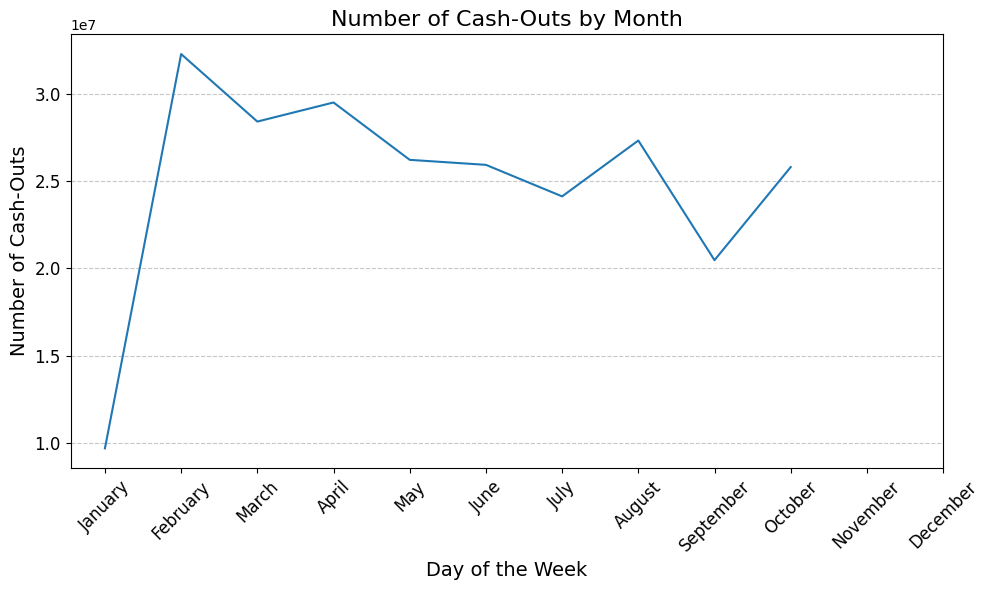

In [33]:
plot_data_grouped(transactions_fees, group_column="month",
                   xticks=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
                   title="Number of Cash-Outs by Month",
                    xlabel="Day of the Week", ylabel="Number of Cash-Outs", plot_func=sns.lineplot)

<Axes: xlabel='date', ylabel='potential_benefits'>

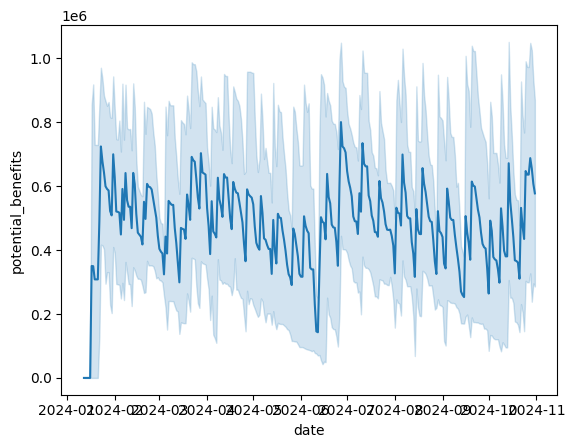

In [34]:
sns.lineplot(transactions_fees, x="date", y="potential_benefits")

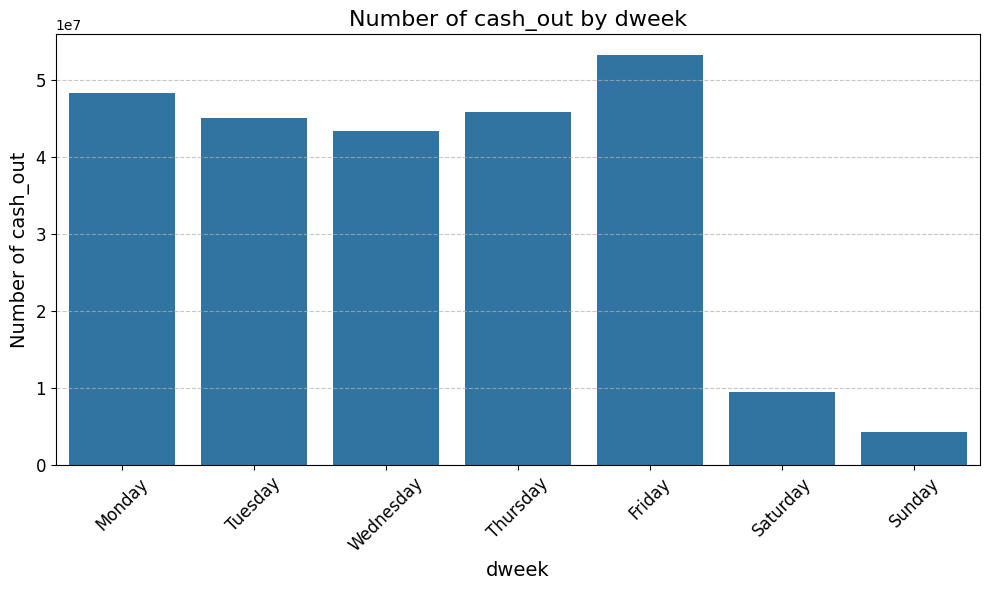

In [37]:
plot_data_grouped(transactions_fees, xticks=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

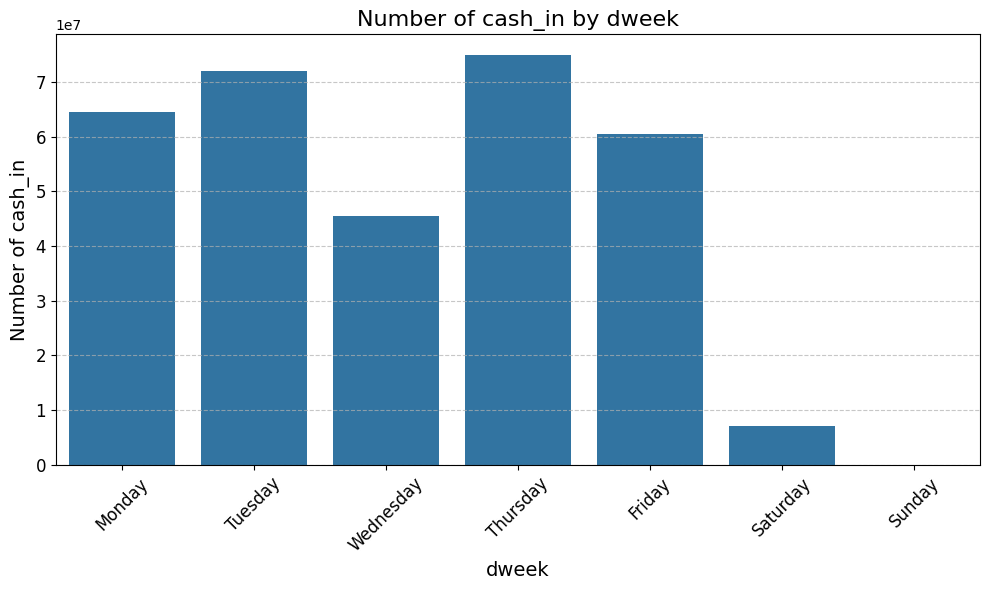

In [38]:
plot_data_grouped(transactions_fees, column="cash_in", xticks=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

Эти фичи могут быть полезными при использовании подхода: __Сведение к задаче Регрессии(ML)__ в последней части задания. Тут мы вывели статистику пополнения и снятие по дням, динамику снятия в зависимости от месяца и график потенциальной выгоды

#### ATM_1

In [187]:
incassary_count(transactions_fees, "ATM_1")
no_cash_out_days(transactions_fees, "ATM_1")

incassary count for ATM_1 is: 22
no cash out days for ATM_1 is: 23


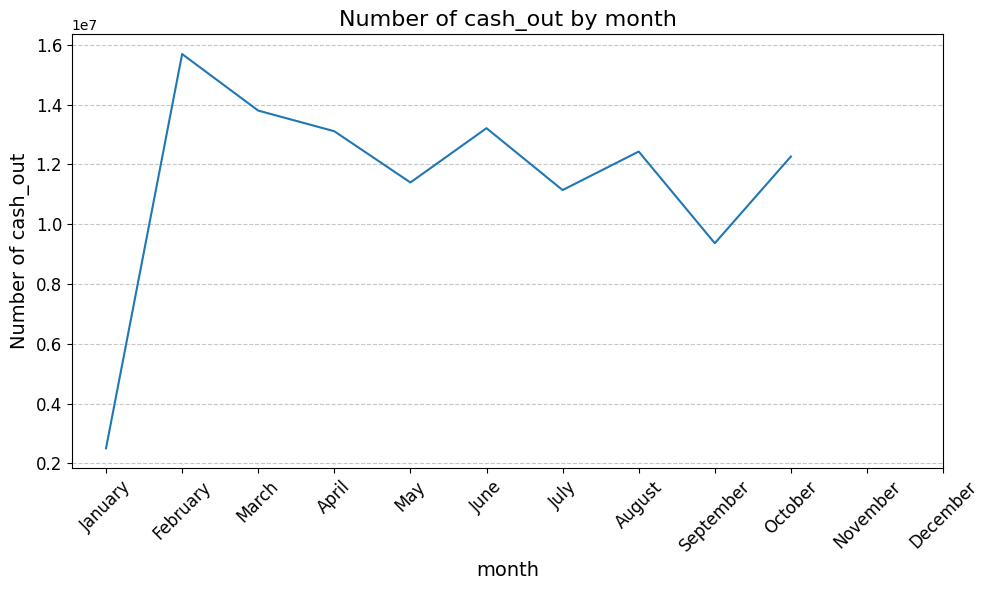

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,rate,potential_benefits,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee,lag_balance,incassary_price,cash_out_calc,dweek,dayofmonth,month
44,2024-01-23,ATM_1,6525100.0,6620000.0,94900.0,16.0,1044016.0,1365.0,0.0001,0.0,0.0,0.0,0.0,0.0,2027.0,-6525100.0,1,23,1
100,2024-02-06,ATM_1,5974000.0,6620000.0,646000.0,16.0,955840.0,1365.0,0.0001,0.0,0.0,0.0,0.0,1528300.0,2027.0,-4445700.0,1,6,2
128,2024-02-13,ATM_1,6396300.0,6620000.0,223700.0,16.0,1023408.0,1365.0,0.0001,0.0,0.0,0.0,0.0,1252200.0,2027.0,-5144100.0,1,13,2
164,2024-02-22,ATM_1,5156900.0,6620000.0,1463100.0,16.0,825104.0,1365.0,0.0001,0.0,0.0,0.0,0.0,1989000.0,2027.0,-3167900.0,3,22,2
212,2024-03-05,ATM_1,6458200.0,6620000.0,161800.0,16.0,1033312.0,1365.0,0.0001,0.0,0.0,0.0,0.0,1828700.0,2027.0,-4629500.0,1,5,3
252,2024-03-15,ATM_1,6258900.0,6620000.0,361100.0,16.0,1001424.0,1365.0,0.0001,0.0,0.0,0.0,0.0,680300.0,2027.0,-5578600.0,4,15,3
304,2024-03-28,ATM_1,6306600.0,6620000.0,313400.0,16.0,1009056.0,1365.0,0.0001,0.0,0.0,0.0,0.0,1489000.0,2027.0,-4817600.0,3,28,3
348,2024-04-08,ATM_1,5864200.0,6620000.0,755800.0,16.0,938272.0,1365.0,0.0001,0.0,0.0,0.0,0.0,233100.0,2027.0,-5631100.0,0,8,4
388,2024-04-18,ATM_1,6303100.0,6620000.0,316900.0,16.0,1008496.0,1365.0,0.0001,0.0,0.0,0.0,0.0,2172700.0,2027.0,-4130400.0,3,18,4
460,2024-05-06,ATM_1,6545500.0,6620000.0,74500.0,16.0,1047280.0,1365.0,0.0001,0.0,0.0,0.0,0.0,1849900.0,2027.0,-4695600.0,0,6,5


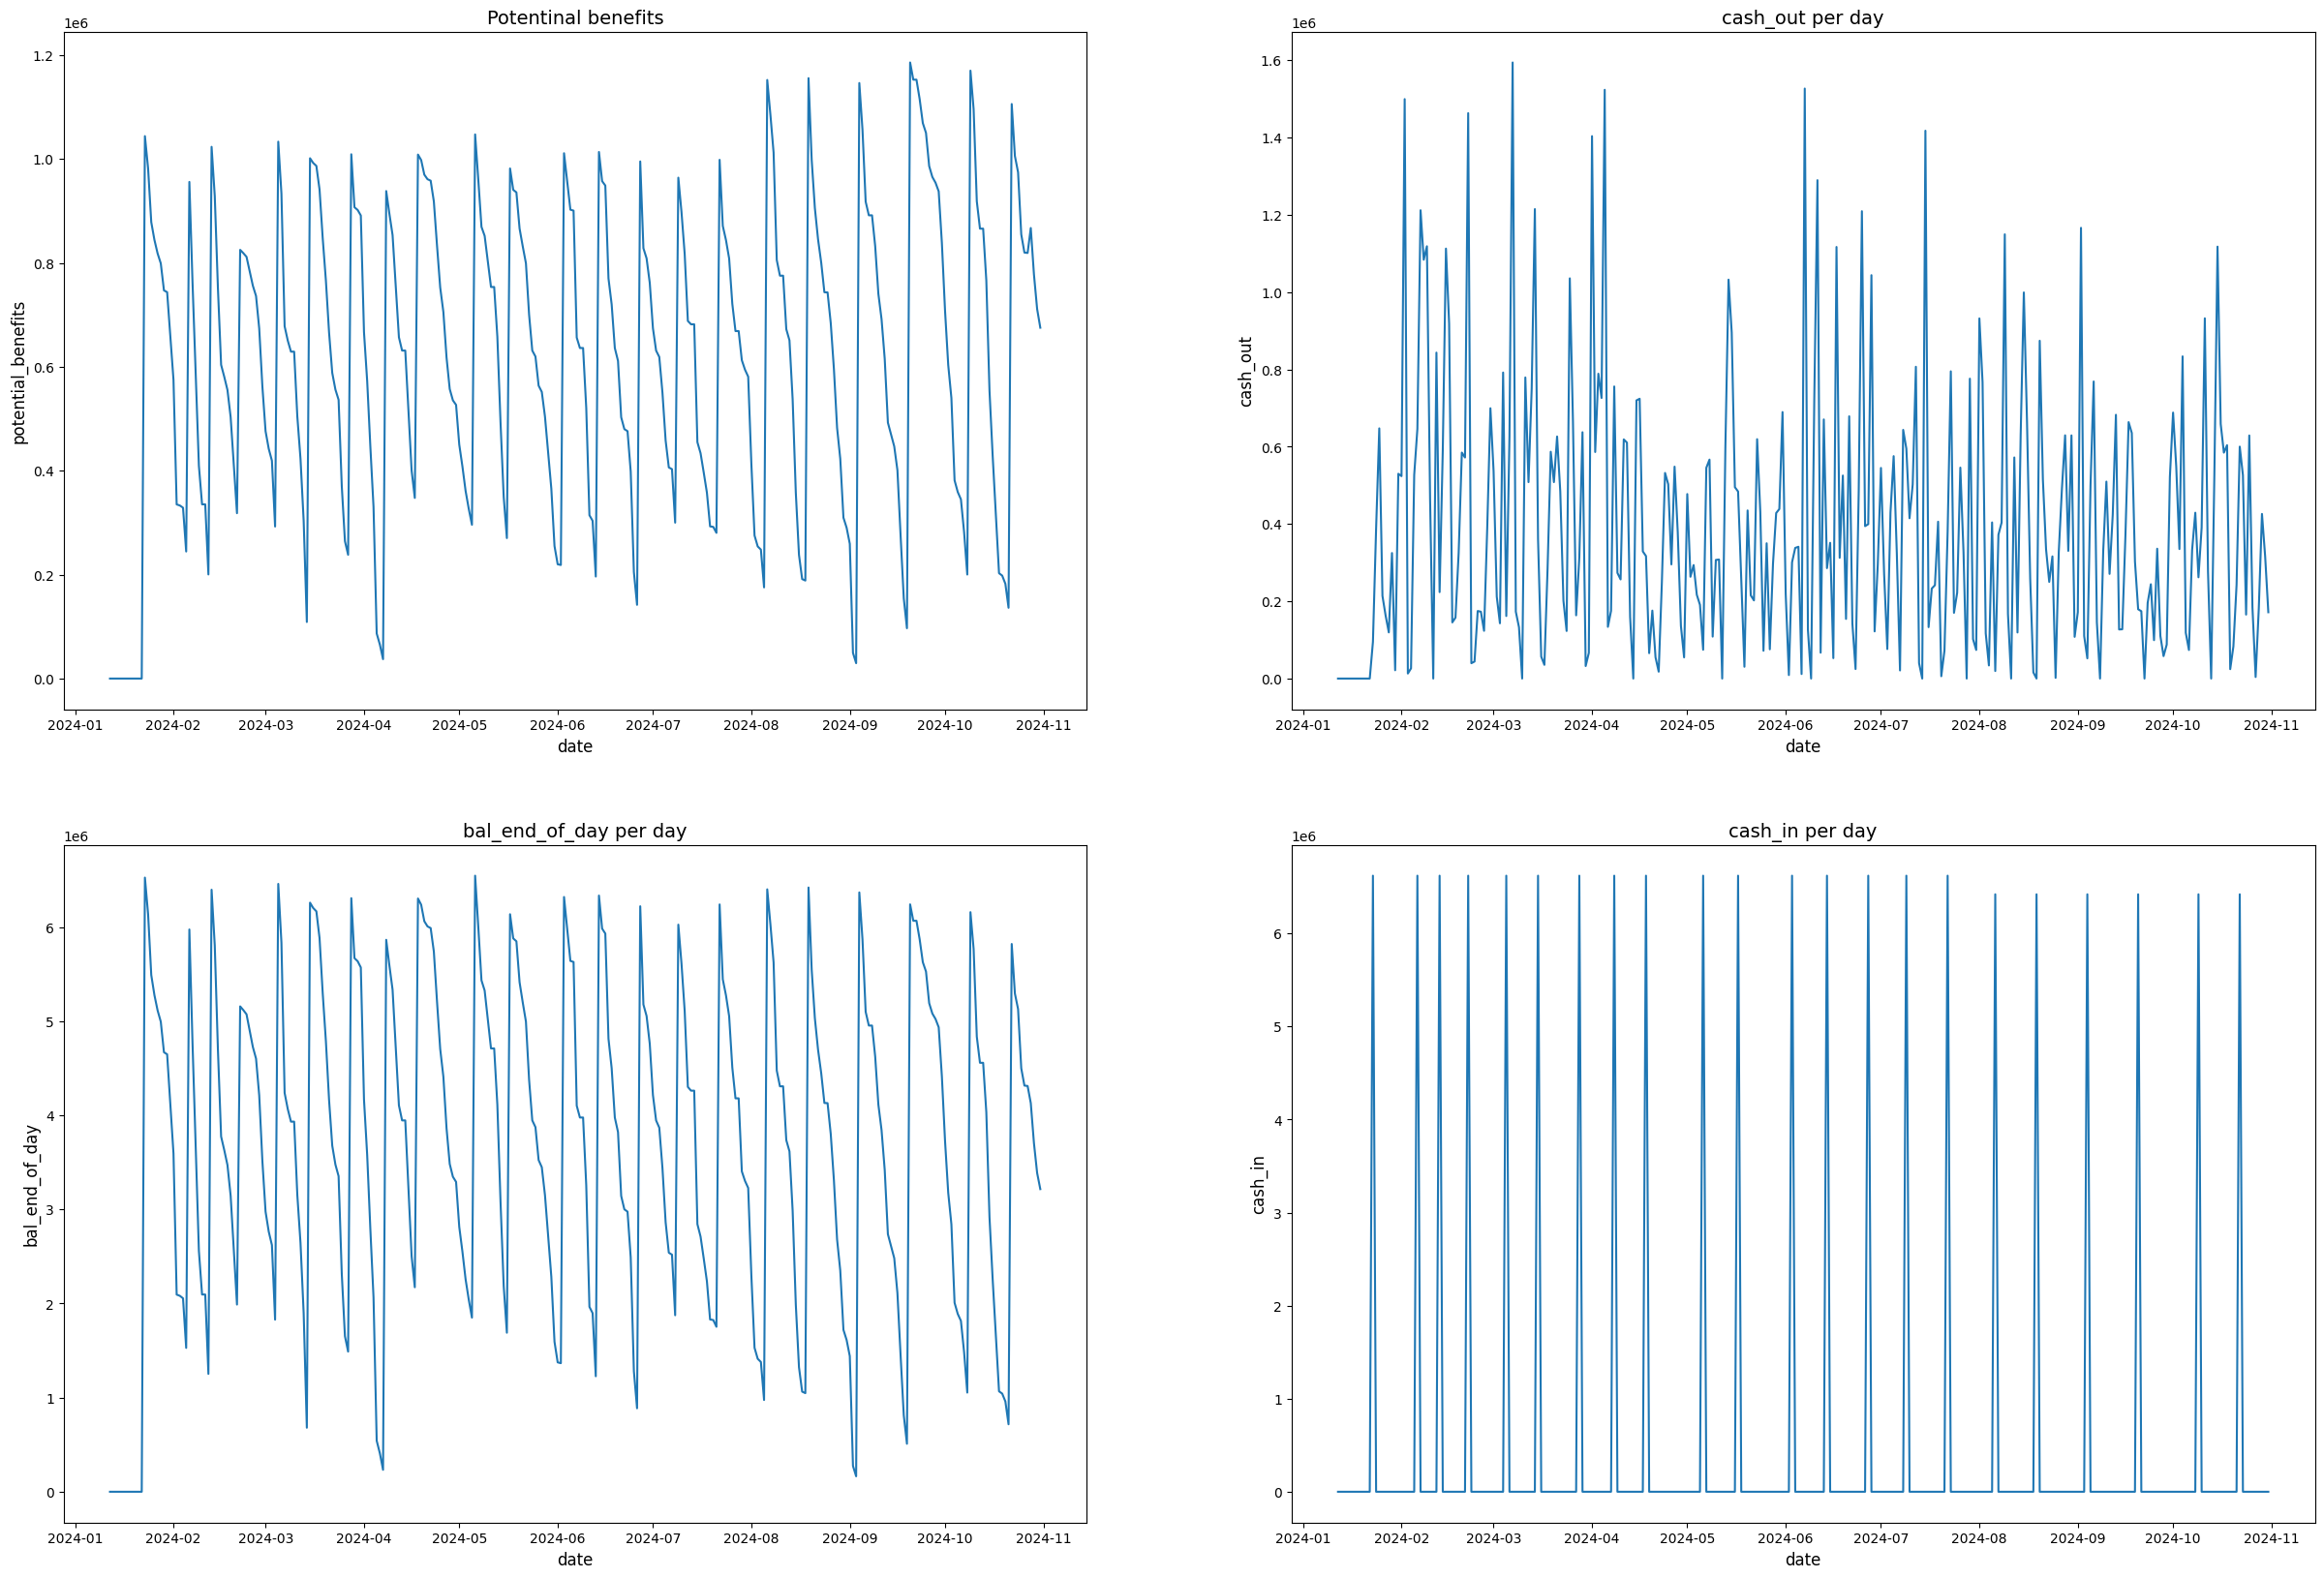

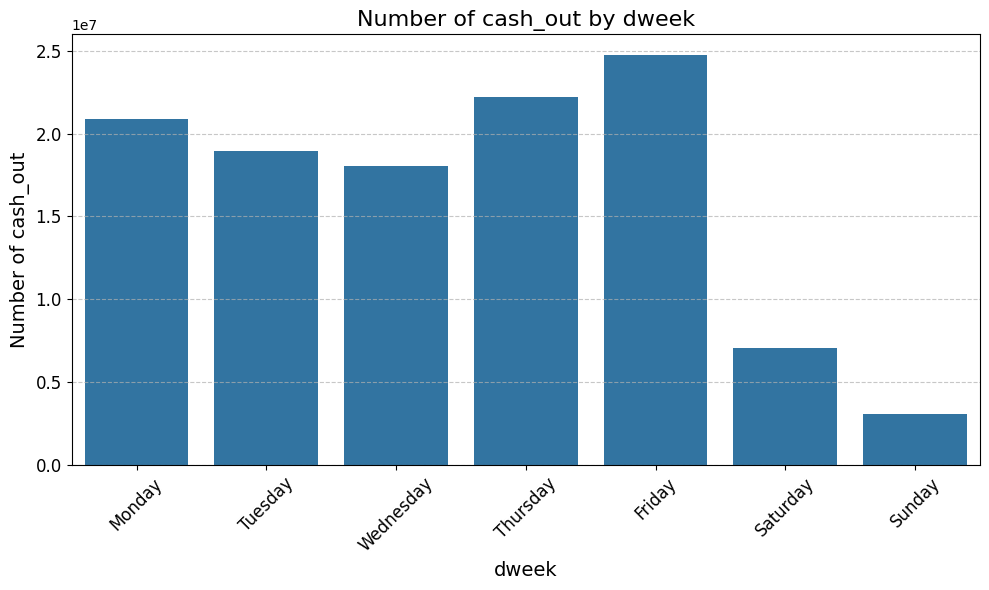

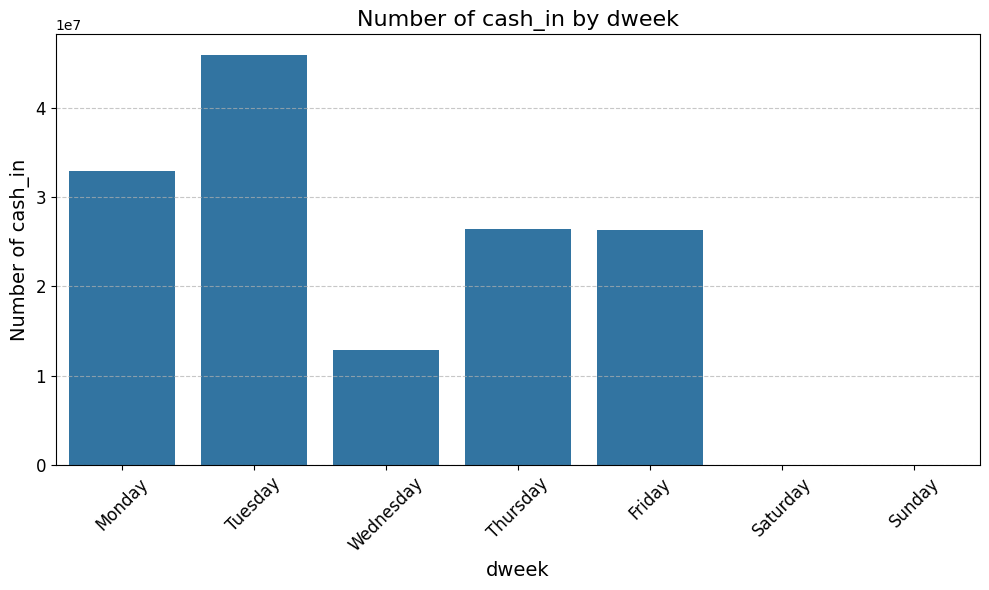

In [58]:
plot_data_per_atm(transactions_fees, "ATM_1")

#### ATM_2

In [188]:
incassary_count(transactions_fees, "ATM_2")
no_cash_out_days(transactions_fees, "ATM_2")

incassary count for ATM_2 is: 22
no cash out days for ATM_2 is: 94


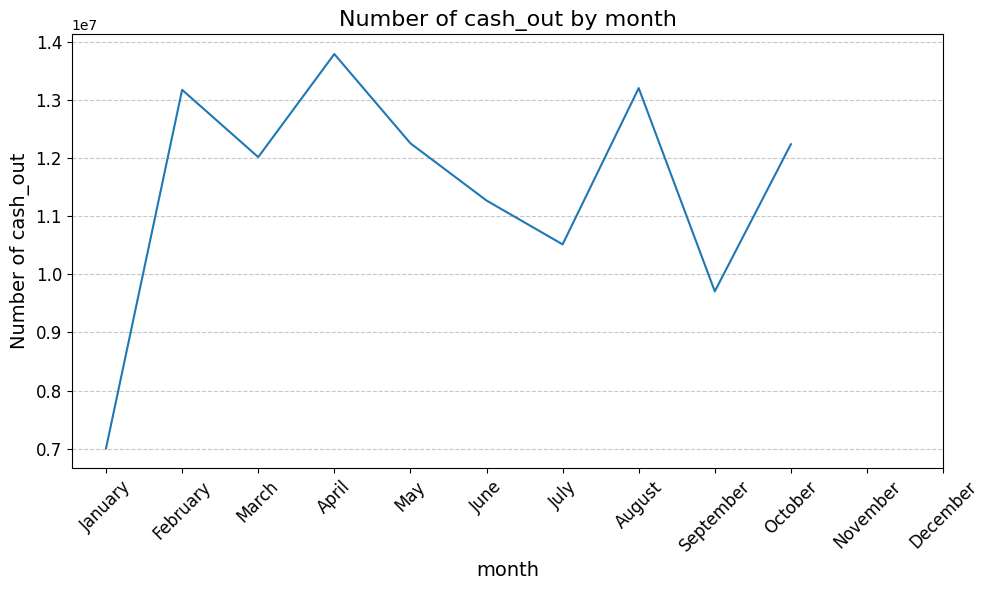

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,rate,potential_benefits,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee,lag_balance,incassary_price,cash_out_calc,dweek,dayofmonth,month
21,2024-01-17,ATM_2,7119900.0,7120000.0,100.0,16.0,1139184.0,1365.0,0.0001,0.0,0.0,0.0,0.0,0.0,2077.0,-7119900.0,2,17,1
29,2024-01-19,ATM_2,6072400.0,7120000.0,1047600.0,16.0,971584.0,1365.0,0.0001,0.0,0.0,0.0,0.0,7104600.0,2077.0,1032200.0,4,19,1
77,2024-01-31,ATM_2,6291800.0,7120000.0,828200.0,16.0,1006688.0,1365.0,0.0001,0.0,0.0,0.0,0.0,955300.0,2077.0,-5336500.0,2,31,1
109,2024-02-08,ATM_2,6415700.0,7120000.0,704300.0,16.0,1026512.0,1365.0,0.0001,0.0,0.0,0.0,0.0,1464500.0,2077.0,-4951200.0,3,8,2
157,2024-02-20,ATM_2,6342000.0,7120000.0,778000.0,16.0,1014720.0,1365.0,0.0001,0.0,0.0,0.0,0.0,2240600.0,2077.0,-4101400.0,1,20,2
221,2024-03-07,ATM_2,6594900.0,7120000.0,525100.0,16.0,1055184.0,1365.0,0.0001,0.0,0.0,0.0,0.0,681700.0,2077.0,-5913200.0,3,7,3
281,2024-03-22,ATM_2,6780000.0,7120000.0,340000.0,16.0,1084800.0,1365.0,0.0001,0.0,0.0,0.0,0.0,1269800.0,2077.0,-5510200.0,4,22,3
333,2024-04-04,ATM_2,6058100.0,7120000.0,1061900.0,16.0,969296.0,1365.0,0.0001,0.0,0.0,0.0,0.0,1107700.0,2077.0,-4950400.0,3,4,4
365,2024-04-12,ATM_2,6552600.0,7120000.0,567400.0,16.0,1048416.0,1365.0,0.0001,0.0,0.0,0.0,0.0,2550500.0,2077.0,-4002100.0,4,12,4
425,2024-04-27,ATM_2,7020000.0,7120000.0,100000.0,16.0,1123200.0,1365.0,0.0001,0.0,0.0,0.0,0.0,820500.0,2077.0,-6199500.0,5,27,4


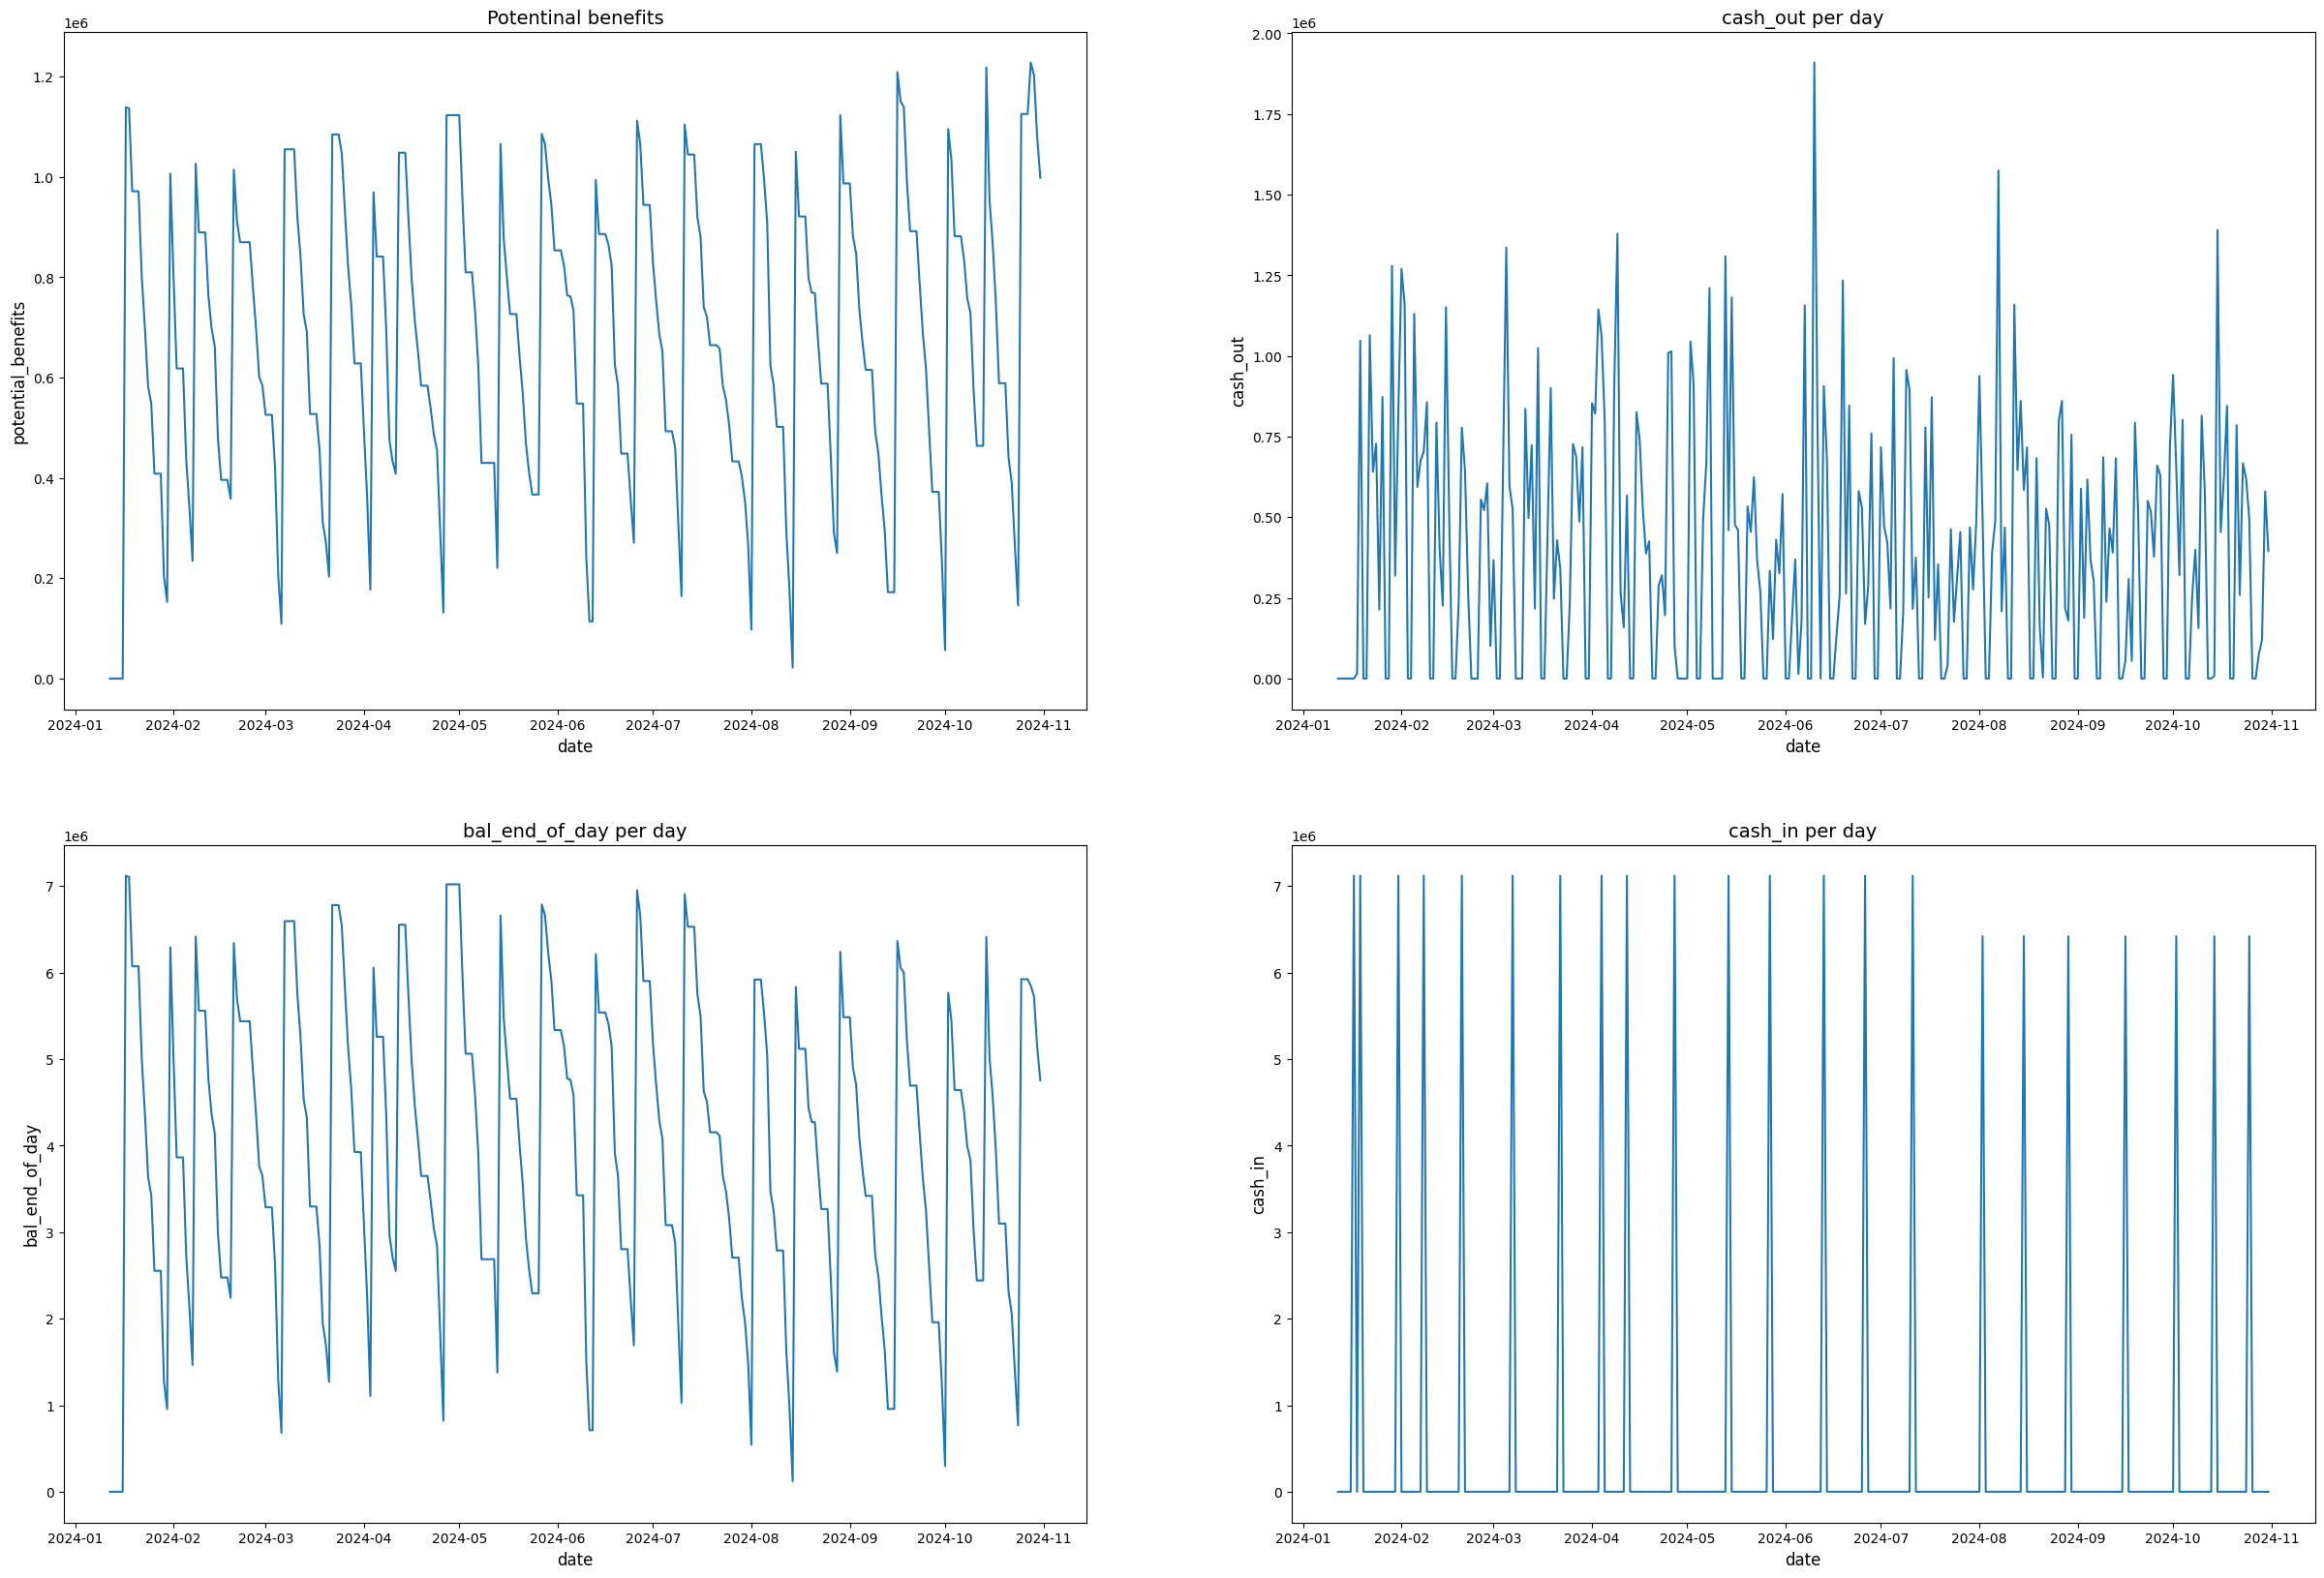

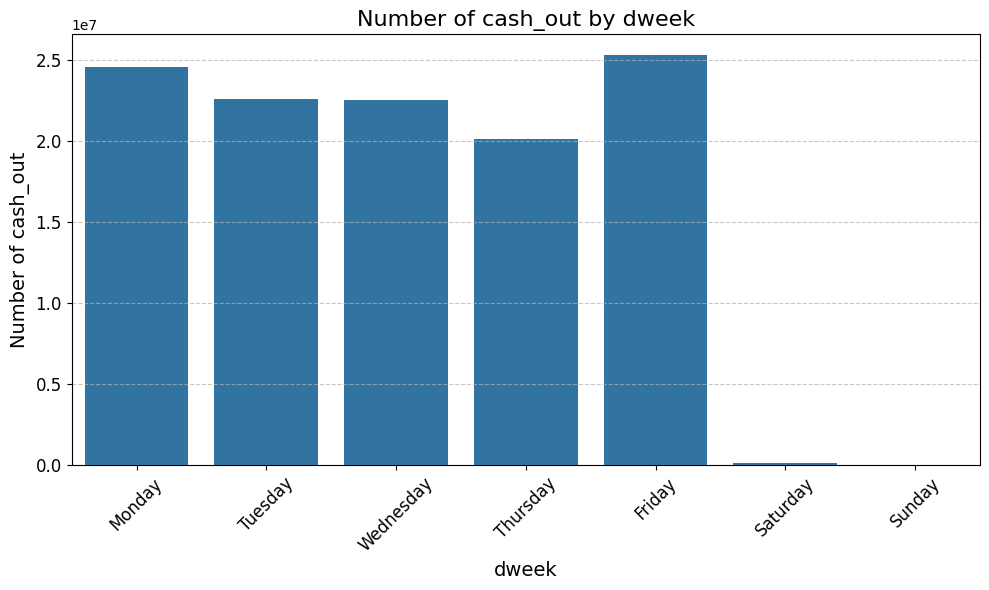

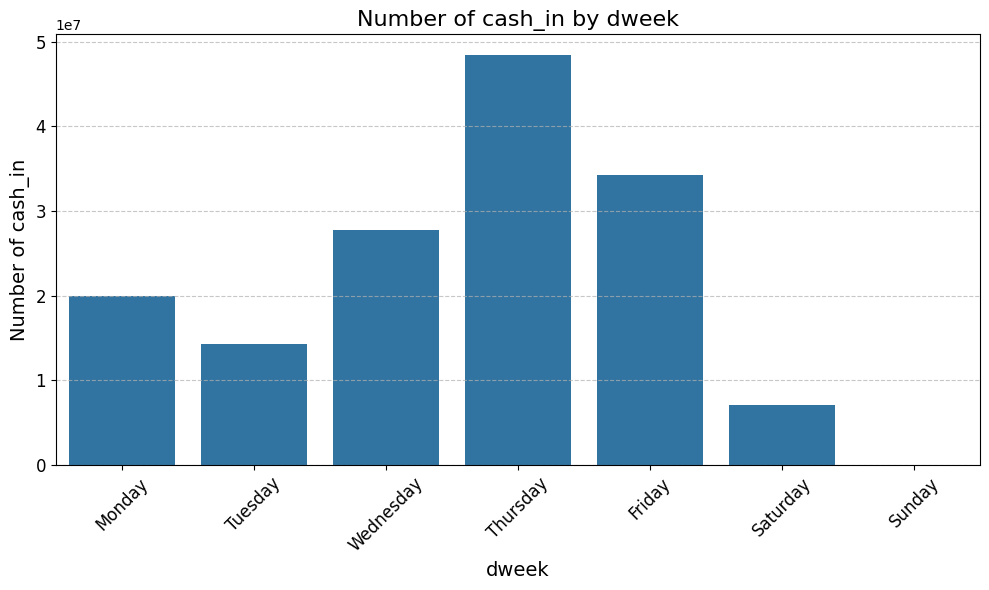

In [60]:
plot_data_per_atm(transactions_fees, "ATM_2")

#### ATM_3

In [189]:
incassary_count(transactions_fees, "ATM_3")
no_cash_out_days(transactions_fees, "ATM_3")

incassary count for ATM_3 is: 5
no cash out days for ATM_3 is: 50


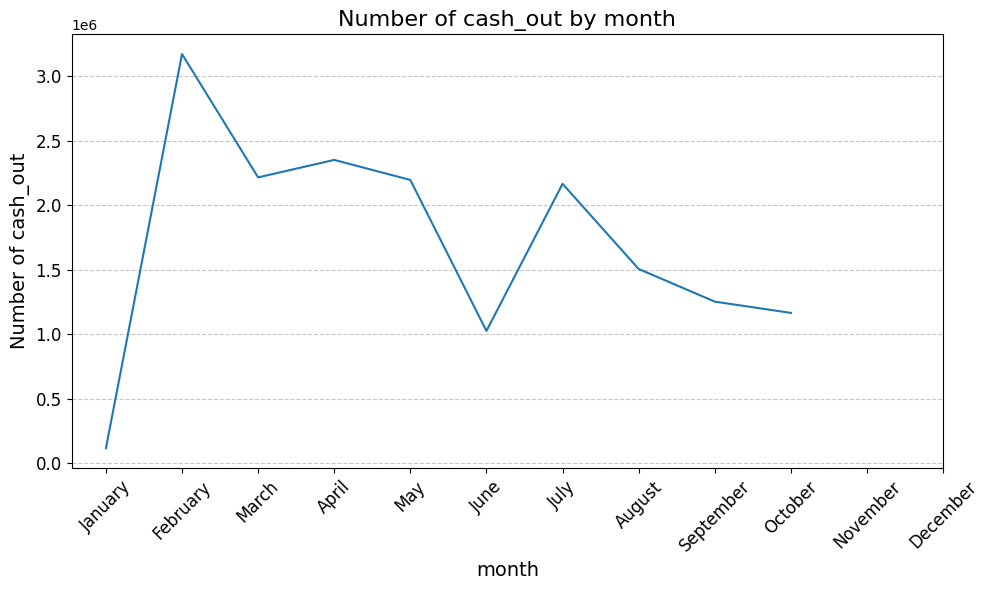

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,rate,potential_benefits,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee,lag_balance,incassary_price,cash_out_calc,dweek,dayofmonth,month
42,2024-01-22,ATM_3,5609800.0,5610000.0,200.0,16.0,897568.0,2250.0,0.0001,675.0,0.0,0.0,0.0,0.0,2925.0,-5609800.0,0,22,1
270,2024-03-19,ATM_3,5739000.0,5850000.0,111000.0,16.0,918240.0,2250.0,0.0001,675.0,0.0,0.0,0.0,781600.0,2925.0,-4957400.0,1,19,3
634,2024-06-18,ATM_3,5925000.0,5980000.0,55000.0,16.0,948000.0,2250.0,0.0001,675.0,0.0,0.0,0.0,141200.0,2925.0,-5783800.0,1,18,6
854,2024-08-12,ATM_3,2894400.0,2980000.0,85600.0,18.0,520992.0,2250.0,0.0001,675.0,0.0,0.0,0.0,2805500.0,2925.0,-88900.0,0,12,8
1106,2024-10-14,ATM_3,2884300.0,2940000.0,55700.0,19.0,548017.0,2250.0,0.0001,675.0,0.0,0.0,0.0,178400.0,2925.0,-2705900.0,0,14,10


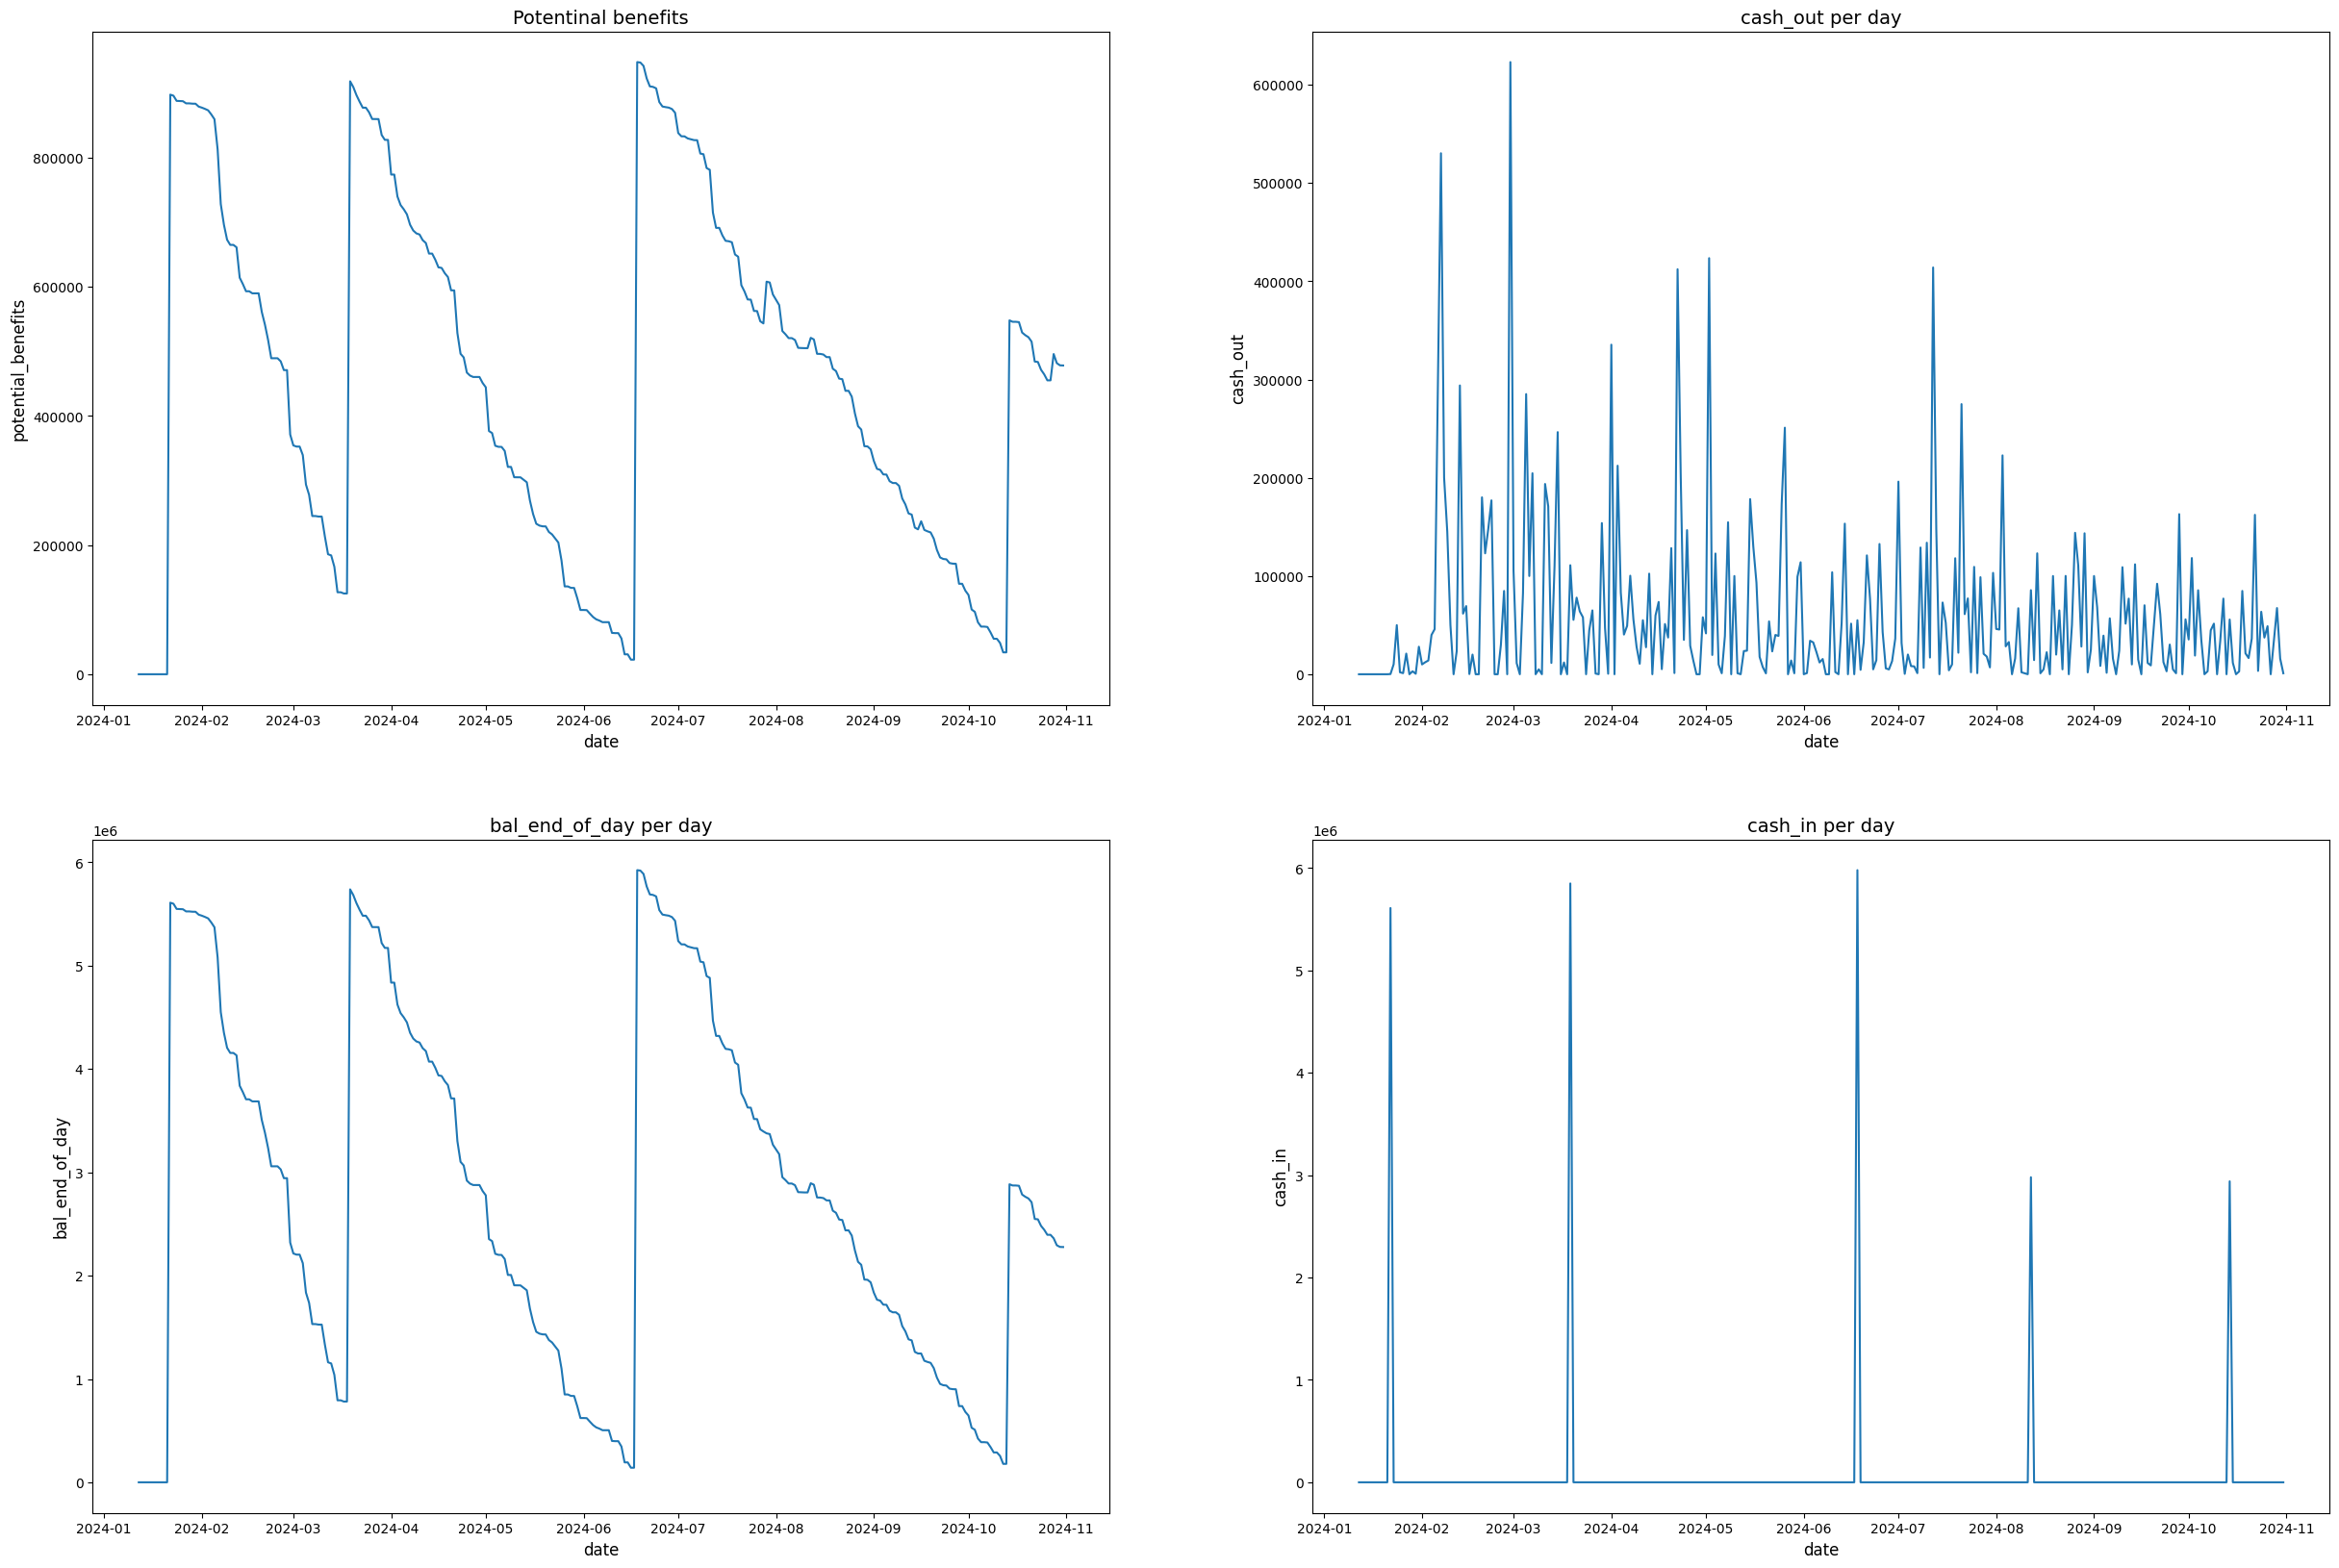

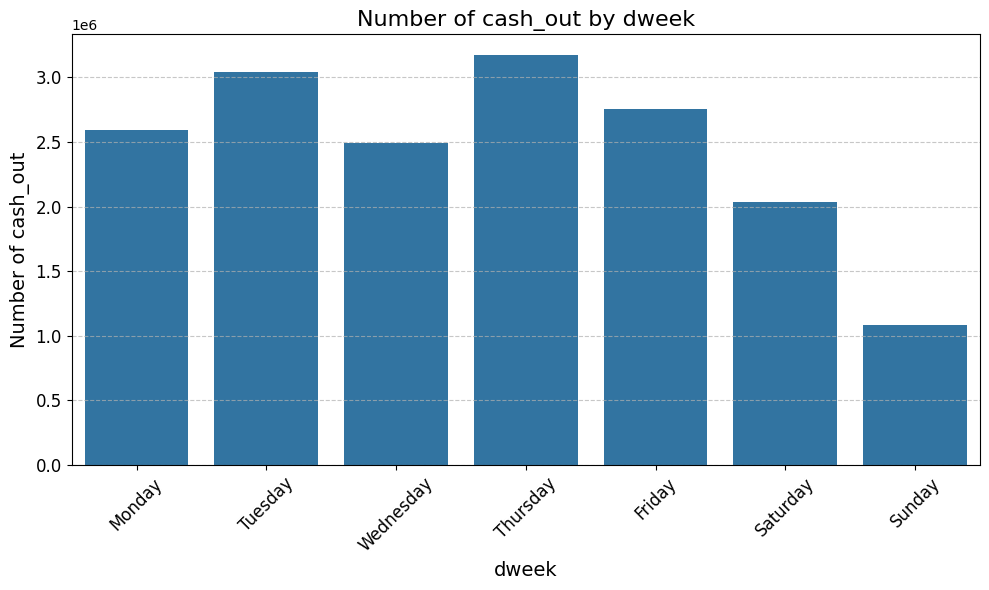

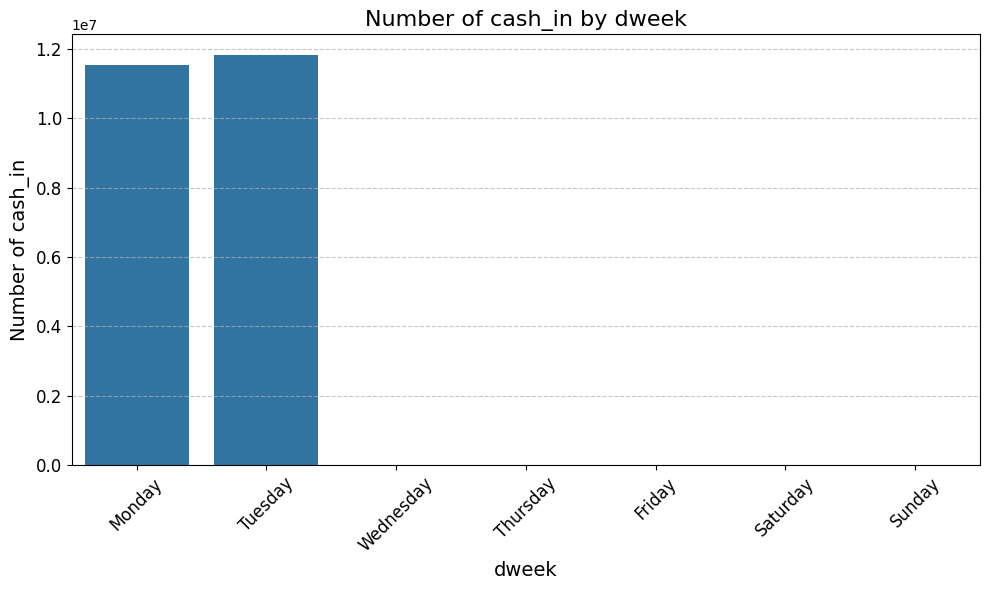

In [61]:
plot_data_per_atm(transactions_fees, "ATM_3")

Тут видно что вначале августа 2024 был небольшой рост. Был день инкассации и т.к. на момент инкассации денег было чуть меньше вводимой суммы, нет столбца вверх

#### ATM_4

In [190]:
incassary_count(transactions_fees, "ATM_4")
no_cash_out_days(transactions_fees, "ATM_4")

incassary count for ATM_4 is: 3
no cash out days for ATM_4 is: 161


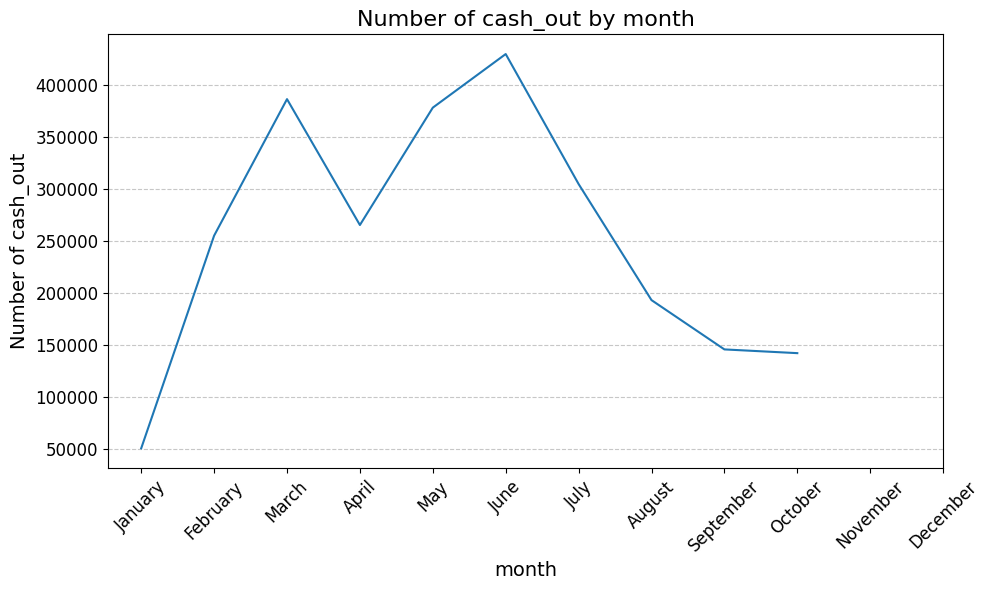

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,rate,potential_benefits,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee,lag_balance,incassary_price,cash_out_calc,dweek,dayofmonth,month
23,2024-01-17,ATM_4,1630000.0,1630000.0,0.0,16.0,260800.0,5250.0,0.0004,450.0,0.0,0.0045,1140.0,0.0,7042.000,-1630000.0,2,17,1
191,2024-02-28,ATM_4,1615000.0,1630000.0,15000.0,16.0,258400.0,5250.0,0.0004,450.0,0.0,0.0045,1140.0,1339700.0,11930.650,-275300.0,2,28,2
667,2024-06-26,ATM_4,1630000.0,1630000.0,0.0,16.0,260800.0,5250.0,0.0004,450.0,0.0,0.0045,1140.0,254450.0,7047.025,-1375550.0,2,26,6


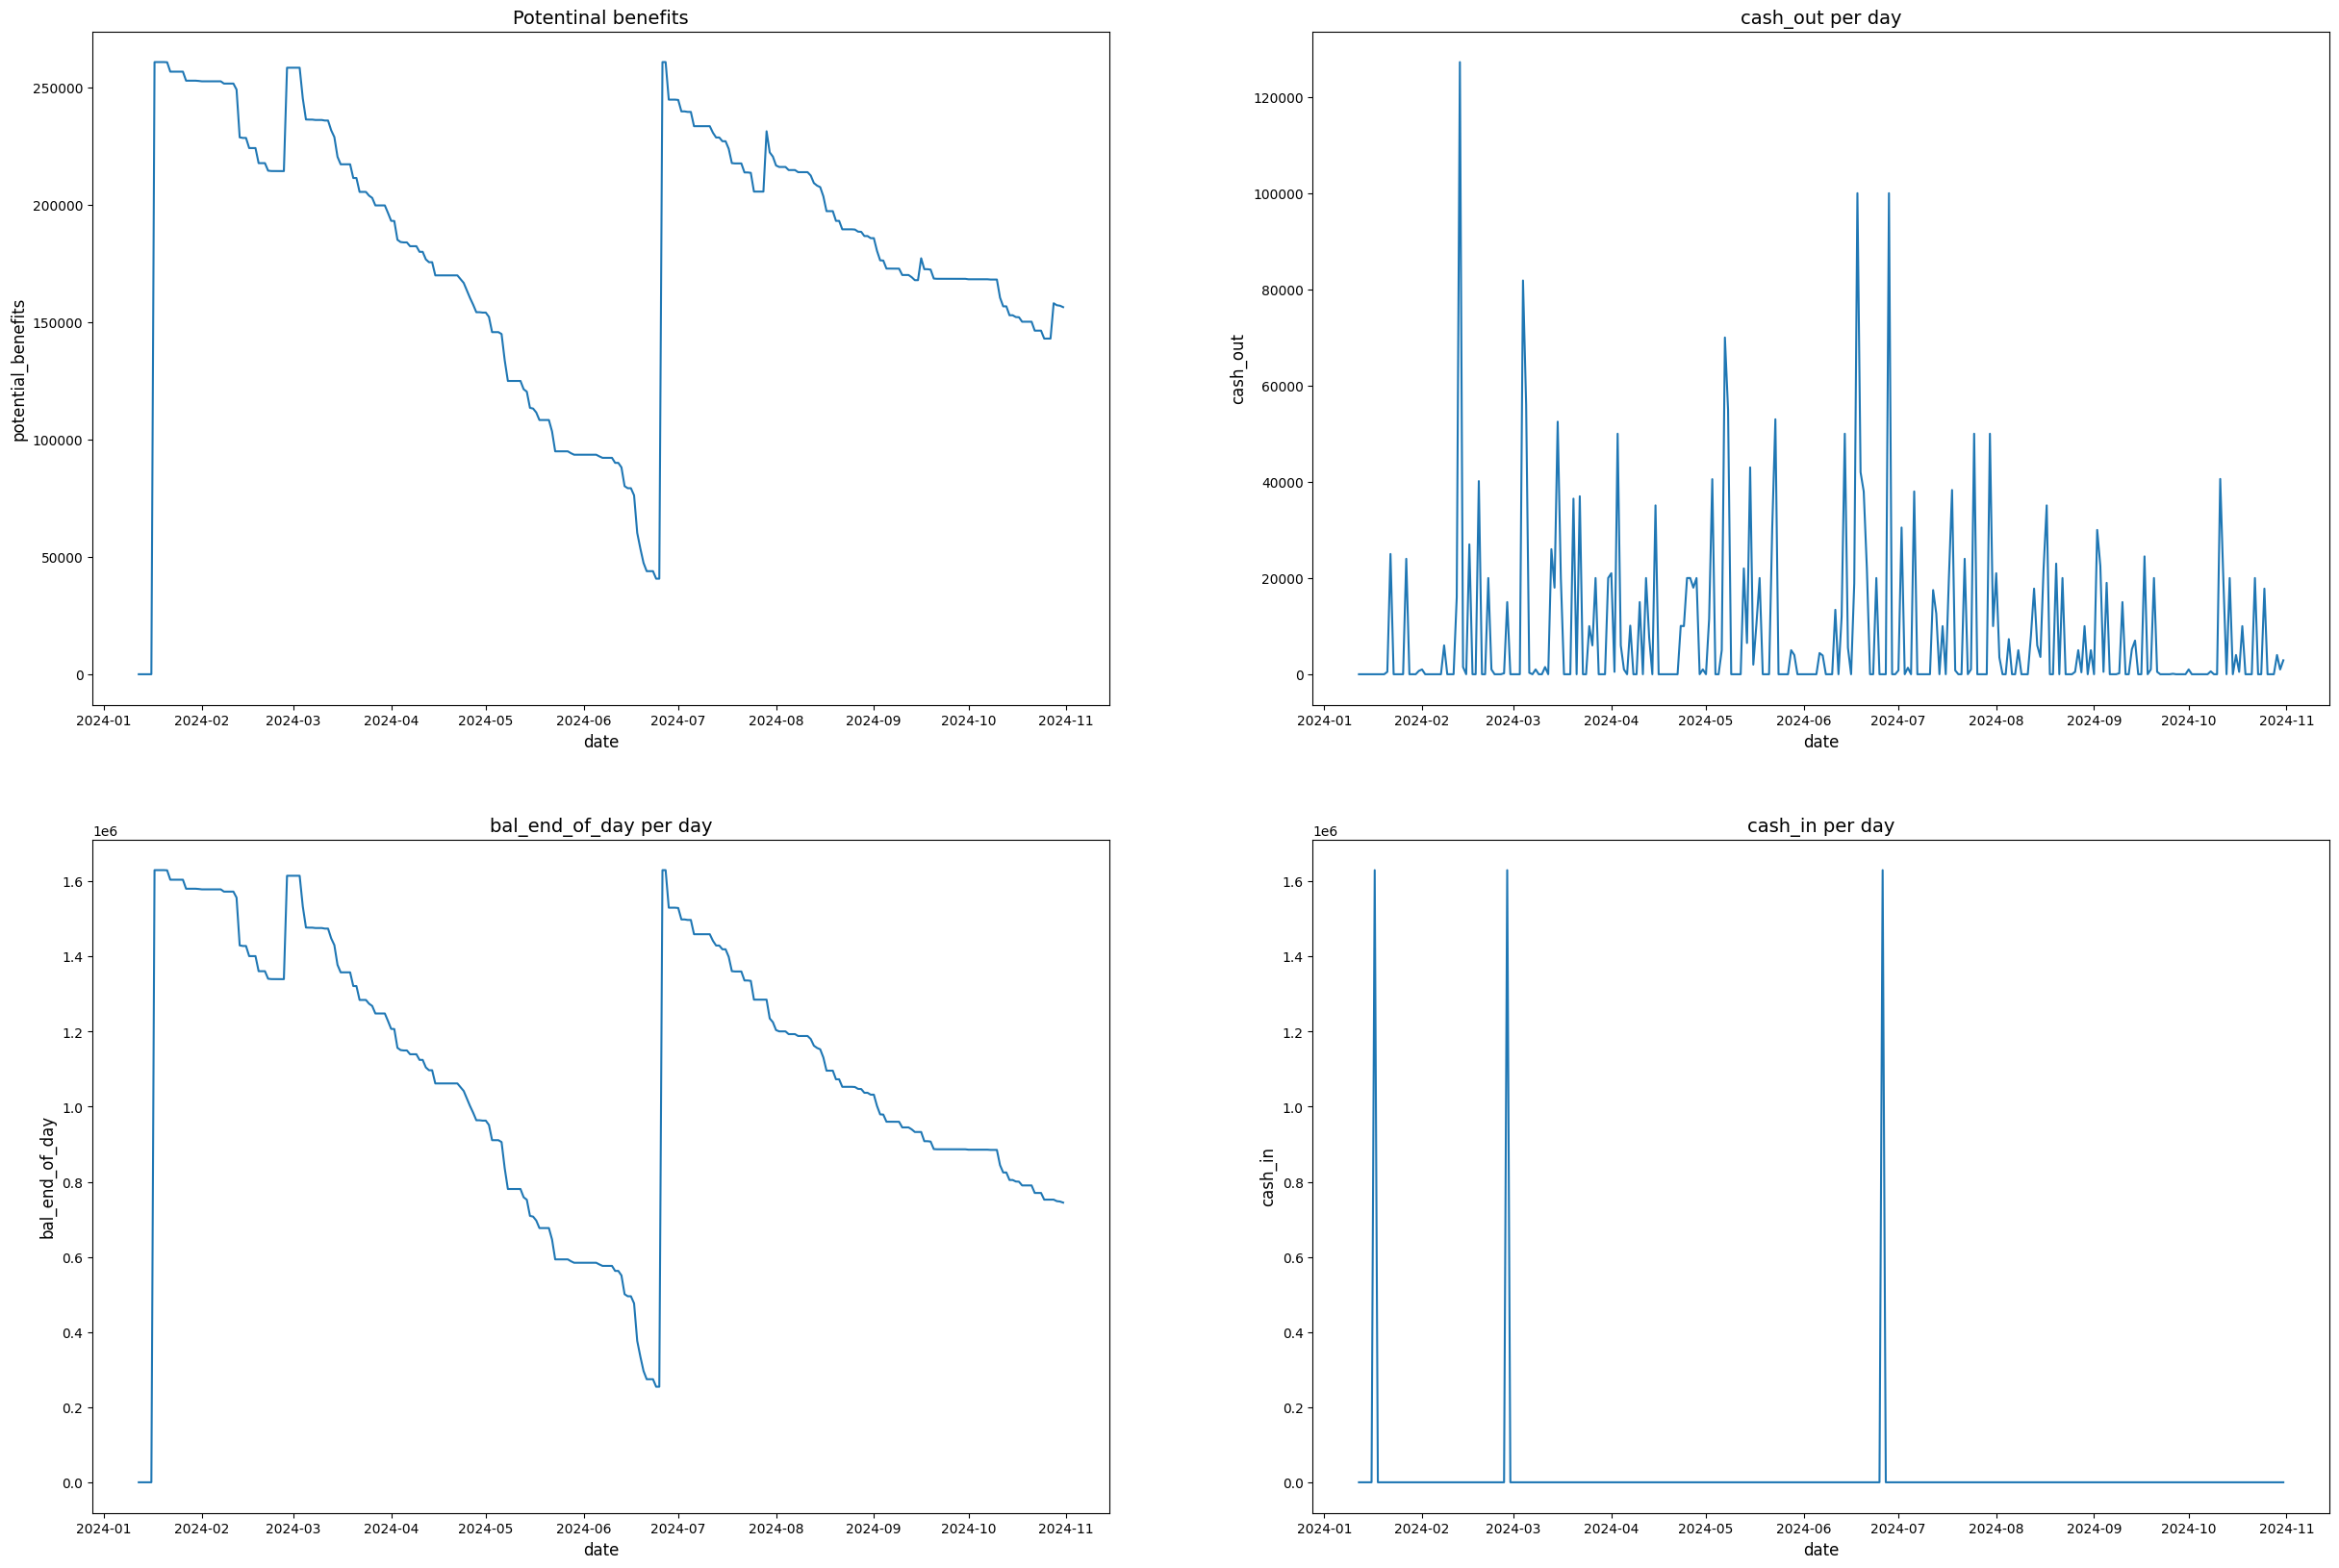

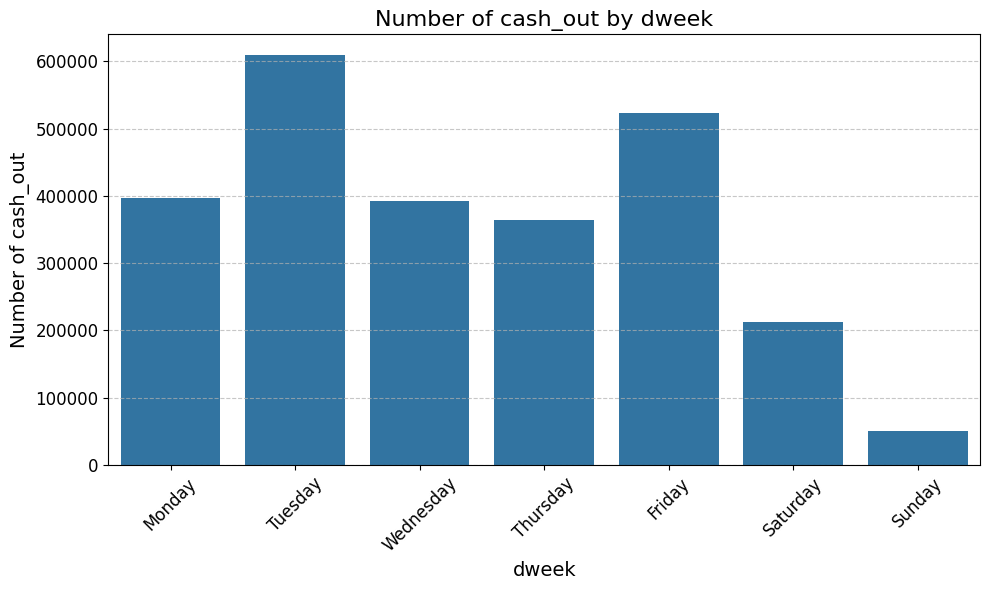

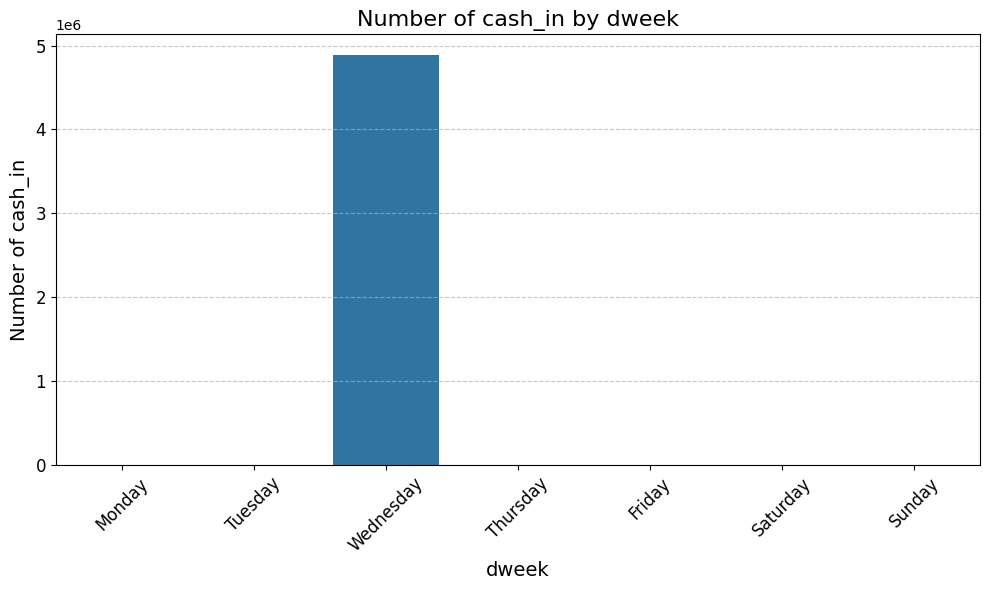

In [62]:
plot_data_per_atm(transactions_fees, "ATM_4")

### Часть 4 - меняем бизнес с помощью ML

Заключительная и самая интересная часть. К данному этапу у нас уже рассчитан упущенный процентный доход и расходы на инкассацию. Подумайте, как использовать ваши знания, чтобы оптимизировать процесс инкассации и уменьшить издержки.

Для данной задачи считаем, что нас устроит Service Level на уровне 90%. Это значит, что если в 9 из 10 случаев наши клиенты получают нужные им суммы, нас это устраивает.

Напоминаем, что технически в банкомат нельзя довнести сумму, и кассета меняется полностью. Соответственно, с нас берут оплату за полную кассету (если вдруг решите подойти к задаче через классическую формулу EOQ).

Вы можете подойти к задаче абсолютно любым способом и использовать все возможности ООП, Python и любых библиотек. Всё как в реальной работе, где вас никто не ограничивает.

Эффективность своего решения вы можете показать с помощью ретротестирования. Считаем, что каждая кассета может вмещать абсолютно любые суммы. Чтобы добавить реализма, вы можете считать, что деньги нужно заказывать за 3 дня до их доставки.


#### Постановка задачи
Для того чтобы уменьшить издержки, можно поделить задачу на несколько:
  * Прогнозировать предполагаемые выводы денег на каждый день для каждого банкомата
  * Основываясь на прогнозах, заказывать инкассацию, когда денег на _ближайшее время_ не хватает
  * Определить интервал _ближайшегго времени_, чтобы минимизировать издержки

Также тут стоит заметить, что уменьшение колчества инкассаций и уменьшение издержек это не одна и та же задача. Поскольку мы можем заказывать инкассацию меньших сум, но чаще. Это для того, чтобы в банкоматах было не так много денег, чтобы большое количество денег не лежало без дела.

Вдальнейшем буду вести замеры и на то удалось ли уменьшить количество инкассаций и издержки на них. Возможно, у нас другие приоритеты, и мы не хотим часто проводить инкассацию опасаясь непредвиденных случаев

#### Анализ временных рядов полученных на третьем шаге

По итогам анализов результатов выше, можно сделать следующие вывод:
  * Сезонность ряды не имеют. Может быть присутствует Цикличность, но на предоставленных данных мы ее не наблюдаем
  * Ряды вывода средств, балансна на конец дня и потенциальной выгоды(интересующие нас ряды) - не обладают свойством Стационарности(использовать _SARIMAX_ не получится:( ) 
  * Данных для анализа не так уж и много. Временной ряд всего один

Из-за всех описанных выше причин, предлагается в качестве основного подхода анализа временных рядов использовать __Статистический подход__

#### Статистический подход

In [81]:
transactions_fees[transactions_fees["cash_out"] > transactions_fees["lag_balance"]]

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,rate,potential_benefits,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,...,CashCollectionPercentageFee,CashCollectionMinFee,lag_balance,incassary_price,cash_out_calc,dweek,dayofmonth,month,projected_cash_out,days_to_exhaustion
44,2024-01-23,ATM_1,6525100.0,6620000.0,94900.0,16.0,1044016.0,1365.0,0.0001,0.0,...,0.0,0.0,0.0,2027.0,-6525100.0,1,23,1,13557.142857,481.303477
348,2024-04-08,ATM_1,5864200.0,6620000.0,755800.0,16.0,938272.0,1365.0,0.0001,0.0,...,0.0,0.0,233100.0,2027.0,-5631100.0,0,8,4,669914.285714,8.753657
21,2024-01-17,ATM_2,7119900.0,7120000.0,100.0,16.0,1139184.0,1365.0,0.0001,0.0,...,0.0,0.0,0.0,2077.0,-7119900.0,2,17,1,NaN,NaN
613,2024-06-13,ATM_2,6213100.0,7120000.0,906900.0,16.0,994096.0,1365.0,0.0001,0.0,...,0.0,0.0,711600.0,2077.0,-5501500.0,3,13,6,682614.285714,9.101919
865,2024-08-15,ATM_2,5835000.0,6420000.0,585000.0,18.0,1050300.0,1365.0,0.0001,0.0,...,0.0,0.0,121800.0,2007.0,-5713200.0,3,15,8,531357.142857,10.981315
1057,2024-10-02,ATM_2,5764500.0,6420000.0,655500.0,19.0,1095255.0,1365.0,0.0001,0.0,...,0.0,0.0,298800.0,2007.0,-5465700.0,2,2,10,515000.000000,11.193204
42,2024-01-22,ATM_3,5609800.0,5610000.0,200.0,16.0,897568.0,2250.0,0.0001,675.0,...,0.0,0.0,0.0,2925.0,-5609800.0,0,22,1,28.571429,196343.000000


Видно, что тут _ServiceLevel_ на уровне 100%. Когда в прошлый день баланса автомата не хватает на новый день, сразу приходит инкассация

Мы же допускаем небольшое понижение _ServiceLevel_(до 90%) для увеличения потенциальной выгоды

##### Seasonal Moving Statistics(Average, Median, ...)

В случае с небольшим количеством данным, хорошим методом будет движущееся окно с некой статистикой(в нашем случае среднее)

In [301]:
def compare_benefits(optimized_df, verbose=True):
    total_sum_no_optimization = optimized_df["potential_benefits"].sum()
    total_incassary_no_optimization = optimized_df["incassary_price"].sum()
    total_sum_optimization = optimized_df["potential_benefits_projected"].sum()
    total_incassary_optimization = optimized_df["incassary_price_projected"].sum()
    
    stat_print = "С оптимизацией упущенная прибыль меньше(Хорошо)" if total_sum_no_optimization > total_sum_optimization else "С оптимизацией упущенная прибыль больше(Плохо)"
    incassary_print = "С оптимизацией комиссии за инкассацию заплачено больше" if total_incassary_optimization > total_incassary_no_optimization else "С оптимизацией комиссии за инкассацию заплачено меньше"
    
    ben_diff_inc = (total_sum_no_optimization - total_sum_optimization) - total_incassary_optimization
    ben_diff = (total_sum_no_optimization - total_sum_optimization)
    ben_prop = 1 - total_sum_optimization/total_sum_no_optimization
    stat_diff_print_incas = f'С оптимизацией удалось заработать на {ben_diff_inc:.2f} больше' if ben_diff_inc > 0 else f'С оптимизацией мы потеряли {(-1) * ben_diff_inc:.2f}'
    stat_diff_print = f'С оптимизацией удалось заработать на {ben_diff:.2f} больше' if ben_diff > 0 else f'С оптимизацией мы потеряли {(-1) * ben_diff:.2f}'
    stat_prop_print = f'С оптимизацией удалось заработать на {ben_prop*100:.2f}% больше чем без' if ben_prop > 0 else f'С оптимизацией мы потеряли {(-1) * ben_diff*100:.2f}%'

    incass_diff = (total_incassary_no_optimization - total_incassary_optimization)
    incass_diff_print = f'Без оптимизацией переплата за комиссию составила: {incass_diff:.2f}' if incass_diff > 0 else f'С оптимизацией переплата за комиссию составила: {(-1) * incass_diff:.2f}'

    if verbose:
        print(f'Упущенная выгода без оптимизации: {total_sum_no_optimization:.2f}')
        print(f'Упущенная выгода с оптимизацией: {total_sum_optimization:.2f}')
        print(stat_print)
        print(stat_prop_print)
        print(incassary_print)
        print(f"Доход с учетом комиссии за инкасацию:")
        print(stat_diff_print_incas)
        print(f"Доход БЕЗ учета комиссии за инкасацию:")
        print(stat_diff_print)
        print(incass_diff_print)
    
    return ben_diff_inc 
        

def get_service_level(optimized_df, col1, verbose=True):
    servise_level = (1 - optimized_df[optimized_df[col1] == 1].shape[0]/optimized_df.shape[0]) * 100
    if verbose:
        print(f'Service level после нашего улучшения: {servise_level}%')
    return servise_level

In [298]:
def simulate_atm_operations(df_transactions, stat='mean', pred_demand_days=2, projected_window=14, service_level=0.9):
    if stat == 'mean':
        df_transactions["projected_cash_out"] = df_transactions.groupby("ATM_ID")["cash_out"].rolling(7).mean().shift().reset_index(0, drop=True)
    elif stat == 'median':
        df_transactions["projected_cash_out"] = df_transactions.groupby("ATM_ID")["cash_out"].rolling(7).median().shift().reset_index(0, drop=True)
        
    df_transactions["days_to_exhaustion"] = df_transactions["bal_end_of_day"] / df_transactions["cash_out"]

    df_transactions["incassation"] = 0
    df_transactions["cash_in_pred"] = 0
    df_transactions["bal_end_of_day_projected"] = 0
    df_transactions["not_enough_money"] = 0
    df_transactions["potential_benefits_projected"] = 0
    df_transactions["days_to_exhaustion_projected"] = 0
    met_first_incassary = True
    for i in range(1, len(df_transactions)):
        if df_transactions.loc[i, "cash_in"] > 0.0 and met_first_incassary:
            df_transactions.loc[i, "bal_end_of_day_projected"] = df_transactions.loc[i, "cash_in"]
            df_transactions.loc[i, "bal_end_of_day_projected"] -= df_transactions.loc[i, "cash_out"]
            met_first_incassary = False
            continue
        predicted_demand = df_transactions.loc[i-pred_demand_days:i, "projected_cash_out"].sum()
        if df_transactions.loc[i, "cash_out"] > df_transactions.loc[i-1, "bal_end_of_day_projected"]:
            df_transactions.loc[i, "not_enough_money"] = 1
        else:
            df_transactions.loc[i, "bal_end_of_day_projected"] = df_transactions.loc[i-1, "bal_end_of_day_projected"] - df_transactions.loc[i, "cash_out"]
        df_transactions.loc[i, "potential_benefits_projected"] = df_transactions.loc[i, "bal_end_of_day_projected"] * (df_transactions.loc[i, "rate"] / 100)
        df_transactions.loc[i, "days_to_exhaustion_projected"] = df_transactions.loc[i, "bal_end_of_day_projected"] / df_transactions.loc[i, "projected_cash_out"]
        if i>=projected_window and df_transactions.loc[i, "bal_end_of_day_projected"] < predicted_demand:
            is_incas = False
            for j in range(0,4):
                if df_transactions.loc[i-j, "incassation"] == 1:
                    is_incas = True
                    break
            if not is_incas: 
                cash_to_load = df_transactions.loc[i-projected_window:i, "projected_cash_out"].sum()
                df_transactions.loc[i, "cash_in_pred"] = cash_to_load
                df_transactions.loc[i, "incassation"] = 1
                df_transactions.loc[i, "bal_end_of_day_projected"] = df_transactions.loc[i-1, "bal_end_of_day_projected"] + cash_to_load
        
    return df_transactions


pred_demand_days_arr = range(6)
projected_window_arr = range(25)

opt_res = {}
statistics = ["mean", "median"]
max_losses = [-1e9, -1e9, -1, -1, ""]
for stat in statistics:
    for prev_days in pred_demand_days_arr:
        for proj_window in projected_window_arr:
            results = []
            for atm_id in transactions_fees["ATM_ID"].unique():
                atm_df = transactions_fees[transactions_fees["ATM_ID"] == atm_id]
                results.append(simulate_atm_operations(atm_df.reset_index(), pred_demand_days=prev_days, projected_window=proj_window, stat=stat))
            optimized_df = pd.concat(results)
            
            optimized_df = optimized_df.sort_values(by=["ATM_ID", "date"])
            optimized_df["lag_balance_projected"] = optimized_df.groupby("ATM_ID")["bal_end_of_day_projected"].shift(1)
            
            optimized_df["incassary_price_projected"] = np.where(
                optimized_df["cash_in_pred"] > 0.0,
                optimized_df["CashDeliveryFixedFee"]
                + np.maximum(
                    optimized_df["CashDeliveryPercentageFee"] * optimized_df["cash_in_pred"],
                    optimized_df["CashDeliveryMinFee"],
                )
                + optimized_df["CashCollectionFixedFee"]
                + np.maximum(
                    optimized_df["CashCollectionPercentageFee"] * optimized_df["lag_balance_projected"],
                    optimized_df["CashCollectionMinFee"],
                ),
                0.0,
            )
            
            optimized_df["incassary_price_projected"] = optimized_df["incassary_price_projected"].fillna(0.0)
            res_comp = compare_benefits(optimized_df, verbose=False)
            sl_comp = get_service_level(optimized_df, "not_enough_money", verbose=False)
    
            if max_losses[0] < res_comp and sl_comp > 90:
                max_losses[0] = res_comp
                max_losses[1] = sl_comp
                max_losses[2] = prev_days
                max_losses[3] = proj_window
                max_losses[4] = stat
            if sl_comp > 90 and res_comp > 0:
                opt_res[(stat, prev_days, proj_window)] = [res_comp, sl_comp]


In [299]:
max_losses

[411393274.3585714, 90.1360544217687, 1, 2, 'mean']

In [300]:
results = []
for atm_id in transactions_fees["ATM_ID"].unique():
    atm_df = transactions_fees[transactions_fees["ATM_ID"] == atm_id]
    results.append(simulate_atm_operations(atm_df.reset_index(), pred_demand_days=1, projected_window=2, stat='mean'))
optimized_df = pd.concat(results)

optimized_df = optimized_df.sort_values(by=["ATM_ID", "date"])
optimized_df["lag_balance_projected"] = optimized_df.groupby("ATM_ID")["bal_end_of_day_projected"].shift(1)

optimized_df["incassary_price_projected"] = np.where(
    optimized_df["cash_in_pred"] > 0.0,
    optimized_df["CashDeliveryFixedFee"]
    + np.maximum(
        optimized_df["CashDeliveryPercentageFee"] * optimized_df["cash_in_pred"],
        optimized_df["CashDeliveryMinFee"],
    )
    + optimized_df["CashCollectionFixedFee"]
    + np.maximum(
        optimized_df["CashCollectionPercentageFee"] * optimized_df["lag_balance_projected"],
        optimized_df["CashCollectionMinFee"],
    ),
    0.0,
)
            
optimized_df["incassary_price_projected"] = optimized_df["incassary_price_projected"].fillna(0.0)
res_comp = compare_benefits(optimized_df)
sl_comp = get_service_level(optimized_df, "not_enough_money")

Упущенная выгода без оптимизации: 566384582.00
Упущенная выгода с оптимизацией: 154563882.86
С оптимизацией упущенная прибыль меньше(Хорошо)
С оптимизацией удалось заработать на 72.71% больше чем без
С оптимизацией комиссии за инкассацию заплачено больше
Доход с учетом комиссии за инкасацию:
С оптимизацией удалось заработать на 411393274.36 больше
Доход БЕЗ учета комиссии за инкасацию:
С оптимизацией удалось заработать на 411820699.14 больше
С оптимизацией переплата за комиссию составила: 297102.11
Service level после нашего улучшения: 90.1360544217687%


При помощи такого простого подхода удалось так хорошо увеличить прибыль(72.71%!!!) и не опуститься ниже SL 90%

При использовании данного стат. подхода в будущее не заглядывали, все полученно легальным путем

__Ответ__: Данный подход можно рассматривать в качестве ответа на задачу

### Заключение

Решение вы можете предоставить любым способом: репозиторий GitHub, Google Colab, конвертированный IPython Notebook в PDF и т. п.

По срокам вас не ограничивают, но учитывайте, что в это же время задачу могут решать и другие кандидаты. Таким образом, вы участвуете в конкурсе с ними.